# **Milestone4: Final Notebook**
## **Problem Statement:**
### **Can search trends related to exercise and obesity effectively predict the actual rates of exercise participation and obesity in the US within a given time period (2005-2018)?**
### NoteBook is basically composed with 4 parts.
#### 1. Data Processing
#### 2. Feature Engineering with Necessary Explorative Data Analysis (EDA)
#### 3. ML Models Prediction & Model Comparison
#### 4. Data Exploration [Previous exploration in Milestone 1-2] (Appendix)

By: **Eva** (Computer Science), **Lihan** (Data Science), **Sean** (Psychology), & **Vickie** (Urban & Environmental Studies)

In [ ]:
# Allow the notebook to use files stored in the user's Drive.
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import all the libraries for future usage.
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 7)
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import mean_absolute_error, r2_score
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

#**1. Data Processing**#






The health datasets contains "health statistics" dataset, "spatial trends" dataset, and "temporal trends" dataset.

Based on our problem statement, we needs **the spatial intensity of Google searches** as well as **obesity and exercise rates** across **various US states** in a time period. According to description in Readme file of the original dataset, we only needs to focus on "health statistics" and "spatial trends" dataset.

Our objective is to use the **Google search data *[spatial intensity of Google searches*]** to predict the **contents of the healthcare statistics dataset**, which includes the **obesity and exercise rates** across various US states over a 15-year period (2004-2018) [*2004 was discarded {Details will be described later}*].

In this context, the **search keywords serve as feature representations**, while the **obesity and exercise rates represent the target values**. The diagram in section 1.3 visually depicts this relationship.

We will start with sections 1.1 and 1.2, which focus on cleaning and processing the data in both datasets to prepare them for future steps.

### *1.1 Processing: Health Statistics (i.e., Target Value)* ###

In [ ]:
# Load the original dataset.
health_pathway = "/content/drive/MyDrive/NYUSH study/Fall 2023/applied data science/health_stats.csv"
health_df = pd.read_csv(health_pathway)
health_df

,Unnamed: 0,ID,Year,...,Stratification,StratificationType,variable
0,0,766058.0,2004.0,...,Overall,Overall,exercise
1,1,766060.0,2004.0,...,Male,Gender,exercise
2,2,766061.0,2004.0,...,Female,Gender,exercise
3,3,766064.0,2004.0,...,18-24,Age Group,exercise
4,4,766065.0,2004.0,...,25-34,Age Group,exercise
...,...,...,...,...,...,...,...
14437,14331,3376875.0,2018.0,...,Overall,Overall,obesity
14438,14332,3376893.0,2018.0,...,Male,Gender,obesity
14439,14333,3376894.0,2018.0,...,Female,Gender,obesity
14440,14334,3377695.0,2018.0,...,Overall,Overall,obesity


In the next cell, we do the following:

*   We keep only the relevant the columns (year, location, value, sample_size, stratification, and obesity/excerise) by dropping the rest.

*   We also drop a few rows which do not contain the data based on U.S. states.

*   We check to make sure that there are no duplicates nor outliers.

*   We drop the rows containing missing data.
* Reasons for directly dropping: they are of tiny proportion (less than 0.3%), relatively sparse, and their removal does not introduce significant bias.





In [ ]:
# Firstly, drop unnecessary columns.
# Equivalently, keep: year, location, value, sample_size, stratification (types and details), and variable (obesity/excerise).
col_to_drop = ["Unnamed: 0", "ID", "LocationAbbr", "Low_Confidence_Limit", "High_Confidence_Limit", "Stratification"]
health_df.drop(col_to_drop, axis=1, inplace=True)
# --------------------
# Secondly, drop unnecessary rows (the ones that interfere with analysis).
row_to_drop = ["All States, DC and Territories (median) **", "All States and DC (median) **"]
condition = ~health_df["LocationDesc"].isin(row_to_drop)
health_df = health_df[condition]
# --------------------
# Thirdly, check for duplicates
#[There are no duplicates in this dataset.]
num_duplicates = health_df.duplicated().sum()
if num_duplicates > 0:
  print(f"Number of duplicate rows: {num_duplicates}.\n\n")
else:
  print("There are no duplicates in this dataset.")

# --------------------
# Fourthly, check for outliers
# There are no outliers in this dataset.

# Convert "Data_Value" from string to numeric, errors="coerce" will transform non-numeric values to NaN.
health_df["Data_Value"] = pd.to_numeric(health_df["Data_Value"], errors="coerce")

# Compute the interquartile range and hence the lower- and upper-bound for outliers.
Q1 = health_df["Data_Value"].quantile(0.25)
Q3 = health_df["Data_Value"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = health_df[(health_df["Data_Value"] < lower_bound) | (health_df["Data_Value"] > upper_bound)]
if outliers.empty:
  print("There are no outliers in this dataset.")
#
nan_rows = health_df[health_df.isna().any(axis=1)].sort_values(by=["LocationDesc", "Year"])
print(nan_rows.shape)
print("Out of the 14,382 rows, 39 rows have missing data, a proportion less than 0.3%.")

# ---------- Show the processed result. ----------
health_df.dropna()
health_df.head()

There are no duplicates in this dataset.
There are no outliers in this dataset.
(39, 6)
Out of the 14,382 rows, 39 rows have missing data, a proportion less than 0.3%.


<ipython-input-35-28e355c7c032>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  health_df["Data_Value"] = pd.to_numeric(health_df["Data_Value"], errors="coerce")


,Year,LocationDesc,Data_Value,Sample_Size,StratificationType,variable
0,2004.0,Alabama,70.4,2449.0,Overall,exercise
1,2004.0,Alabama,73.3,886.0,Gender,exercise
2,2004.0,Alabama,67.7,1563.0,Gender,exercise
3,2004.0,Alabama,79.0,177.0,Age Group,exercise
4,2004.0,Alabama,74.8,397.0,Age Group,exercise


In the next cell, we do the following:

*   Select only the "overall" in the "StratificationType" column, then drop the now-redundant "StratificationType" column.

*   Select the "exercise" and "obesity" in the "variable" column to form new data frames, then drop the now-redundant "variable" column.

Although the first step operates within the original data frame while the second step aims to create new dataframes, you can see that the roles are largely similar. Therefore, we write a **function, select_and_drop**, to achieve both steps.  

The outputs are two dataframes, containing the obesity and exercise rates, respectively.

In [ ]:
# Create a function to filter by values in a column and then drop the column.
def select_and_drop(df, header, entry):
  new_df = df[df[header] == entry]
  new_df = new_df.drop(header, axis=1)
  return new_df.reset_index(drop=True)

# Keep the data under "overall" Stratification.
health_df = select_and_drop(health_df, "StratificationType", "Overall")

# Divide the data into obesity and exercise.
health_obesity_df = select_and_drop(health_df, "variable", "obesity")
health_exercise_df = select_and_drop(health_df, "variable", "exercise")

print(health_obesity_df.head(), end="\n\n")
print(health_exercise_df.head())

     Year LocationDesc  Data_Value  Sample_Size
0  2004.0      Alabama        28.8       1001.0
1  2004.0       Alaska        23.7        633.0
2  2004.0      Arizona        21.2        992.0
3  2004.0     Arkansas        26.1       1015.0
4  2004.0   California        22.2        934.0

     Year LocationDesc  Data_Value  Sample_Size
0  2004.0      Alabama        70.4       2449.0
1  2004.0       Alaska        79.4       2086.0
2  2004.0      Arizona        75.8       3602.0
3  2004.0     Arkansas        73.5       2910.0
4  2004.0   California        77.3       3544.0


In the following cells, we explore how complete the data are, in a sense that:

*   Does the dataset contain each of the 50 states in the US?

*   Does the dataset contain any more regions in the US that are not considered as states?

*   Does the dataset contain complete data within the timespan (i.e., 2004-2018, 15 years)?



In [ ]:
# This cell gives a broader sense of the data.
  # A more rigorous function is written in the following cells to give solid conclusions.
unique_counts_obesity = health_obesity_df["LocationDesc"].value_counts()
unique_counts_exercise = health_exercise_df["LocationDesc"].value_counts()
print("Number of states for obesity:", len(unique_counts_obesity))
print(unique_counts_obesity, end="\n\n")
print("Number of states for exercise:", len(unique_counts_obesity))
print(unique_counts_exercise)

Number of states for obesity: 54
Alabama                 15
Nebraska                15
New Hampshire           15
New Jersey              15
New Mexico              15
New York                15
North Carolina          15
North Dakota            15
Ohio                    15
Oklahoma                15
Oregon                  15
Pennsylvania            15
Puerto Rico             15
Rhode Island            15
South Carolina          15
South Dakota            15
Tennessee               15
Texas                   15
Utah                    15
Vermont                 15
Virginia                15
Washington              15
West Virginia           15
Wisconsin               15
Wyoming                 15
Alaska                  15
Nevada                  15
Montana                 15
Missouri                15
Arizona                 15
Arkansas                15
California              15
Colorado                15
Connecticut             15
Delaware                15
District of Columbia  

**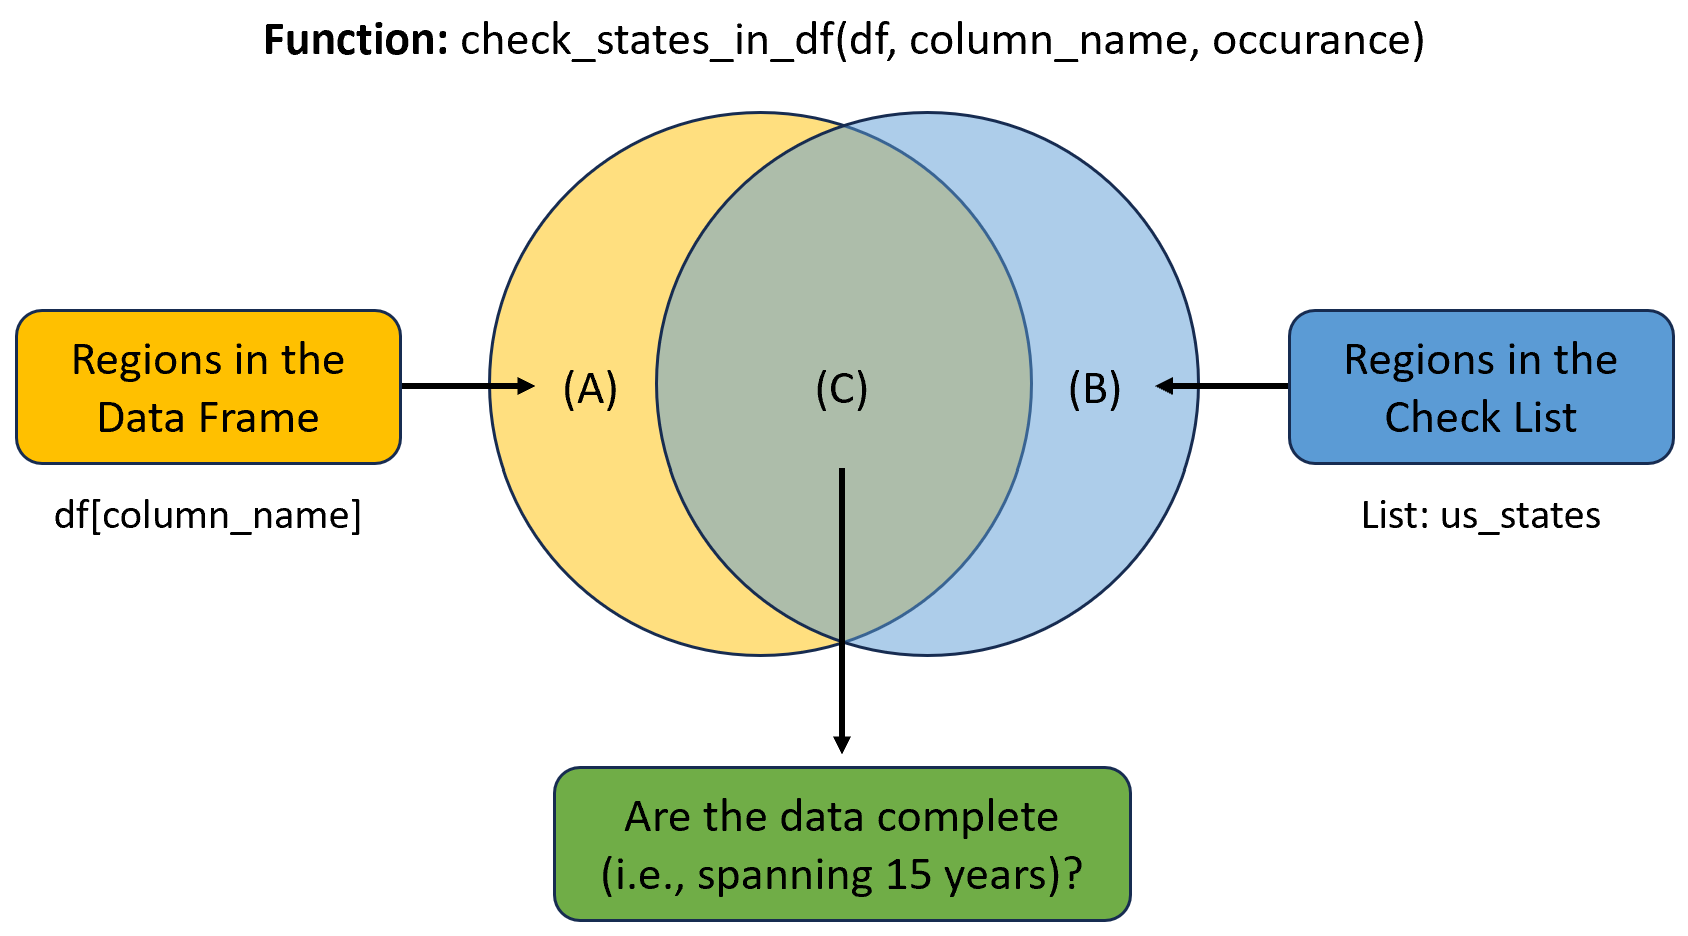

Since we have a dataset with US regions and a list, us_states, containing all the 50 states in the US, the function below basically checks three things, as illustrated by the diagram:


*   A: Are there any regions in our datasets that are not considered as US states? If so, we might need to add more regions.

*   B: Are there any US states that are not included in our dataset? If so, we need to check whether that state is indeed missing or it is just with different names.

*   C: For the existing data, do they have a timespan of 15 years? If some states have missing values, we will need to address accordingly, either by dropping or filling.



In [ ]:
def check_states_in_df(df, column_name, occurance):
  # List of all 50 US states. Source: from the Internet.
  us_states = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California",
    "Colorado", "Connecticut", "Delaware", "Florida", "Georgia",
    "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa",
    "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland",
    "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri",
    "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey",
    "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio",
    "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina",
    "South Dakota", "Tennessee", "Texas", "Utah", "Vermont",
    "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
  ]

  # States in the DataFrame
  states_in_df = set(df[column_name])

  # As per (A), check for states not in the list of US states
  non_us_states = [state for state in states_in_df if state not in us_states]
  if non_us_states:
      print(f"States not in the list of US states: {non_us_states}")
  else:
      print("All states in the column are valid US states.")

  # As per (B), check for missing states in our data.
  missing_states = [state for state in us_states if state not in states_in_df]
  if missing_states:
    print(f"Missing State: {missing_states}")
  else:
    print("No state is missing.")

  # As per (C), check for incomplete states (undesirable orrurances) in our data.
  state_counts = df[column_name].value_counts()
  states_incomplete = [state for state in us_states if state_counts.get(state, 0) < occurance]
  if states_incomplete:
    print(f"State with incomplete data: {states_incomplete}")
  else:
    print("All states have complete data.")

print("For obesity:")
health_obesity_check = check_states_in_df(health_obesity_df, "LocationDesc", 15)
print()
print("For exercise:")
health_exercise_check = check_states_in_df(health_exercise_df, "LocationDesc", 15)

For obesity:
States not in the list of US states: ['District of Columbia', 'Guam', 'Puerto Rico', 'Virgin Islands']
No state is missing.
State with incomplete data: ['Hawaii']

For exercise:
States not in the list of US states: ['District of Columbia', 'Guam', 'Puerto Rico', 'Virgin Islands']
No state is missing.
State with incomplete data: ['Hawaii']


### *1.2 Processing: Search Trends (i.e., Feature Representation)* ###

We load the dataset for Search Trends and check to make sure that there are no duplicates or missing values.

For Outliers, firstly, it is commonplace to encounter outliers in search quantity data, as these figures can vary substantially over time and across different locations. Secondly, given that all the data points are authentic, it does not make sense to selectively retain certain data while excluding others.Therefore, there is no need to check for outliers.

**Fortunately, no duplicates, no missing data.**

In [ ]:
# Load the original dataset.
spatial_pathway = "/content/drive/MyDrive/NYUSH study/Fall 2023/applied data science/spatial_trends.csv"
spatial_df = pd.read_csv(spatial_pathway)
# Process for checking duplicates and missing data is the same as the health statistics
# There are no duplicates in this dataset.
# The are no missing data in this dataset.
# There is no need to check for outliers.

# Rename the state column from "geoName" to "LocationDesc" for future merging.
spatial_df.rename(columns={"geoName": "LocationDesc", "year": "Year"}, inplace=True)
spatial_df

,Unnamed: 0,LocationDesc,Year,...,wellness,workout,yoga
0,0,Alabama,2004,...,41.0,78.0,28.0
1,1,Alaska,2004,...,33.0,75.0,44.0
2,2,Arizona,2004,...,33.0,76.0,72.0
3,3,Arkansas,2004,...,10.0,71.0,39.0
4,4,California,2004,...,32.0,66.0,87.0
...,...,...,...,...,...,...,...
760,760,Virginia,2018,...,38.0,89.0,49.0
761,761,Washington,2018,...,33.0,83.0,64.0
762,762,West Virginia,2018,...,32.0,78.0,32.0
763,763,Wisconsin,2018,...,44.0,82.0,49.0


**Since the target values are obesity and exercise rates, we will have to fetch keywords (i.e., feature representations) that are relevant to each target value.**

Since machine learning helps people identify the patterns, we will now keep as many keywords as possible (we will further process these keywords in feature engineering).

Therefore, among the 81 keywords, except 5 words that apparently have no connections with either of obesity or exercise, the rest are categorized into each, ending up 44 for obesity and 32 for exercise.

In [ ]:
all_keywords = [
  'NIH', 'abdominal', 'aerobic exercise', 'apnea', 'best workout',
  'bike helmet', 'bike laws', 'bike locks', 'bike repair', 'bike sale',
  'bodybuilding', 'calories', 'cholesterol', 'diabetes insipidus',
  'diabetes insulin', 'diabetes mellitus', 'diabetes symptoms',
  'diabetes', 'diabetic diet', 'diabetic ketoacidosis', 'diabetic',
  'diet', 'dietary', 'dresses plus size', 'e-bike', 'ejercicios',
  'endocrine', 'exercise', 'exercises', 'fitbit', 'fitness gym',
  'fitness', 'food delivery near me', 'gastric', 'glucose', 'glycogen',
  'gym near me', 'gym', 'healthy', 'how to exercise',
  'how to lose weight', 'hyperglycemia', 'hypertension', 'iPod',
  'icd 10 codes', 'inactivity', 'insanity workout', 'insulin syringes',
  'insulin', 'ipod reset', 'jogging', 'ketoacidosis', 'malnutrition',
  'meals', 'my fitness pal', 'nutrition', 'obese', 'obesity',
  'pizza delivery', 'polyphagia', 'pre workout', 'prediabetes',
  'quinoa gluten free', 'sclerosis', 'signs of diabetes', 'slim',
  'sugar level', 'symptoms of congestive heart failure',
  'symptoms of diabetes', 'symptoms of high blood sugar', 't25 schedule',
  'trainer', 'type 2 diabetes', 'type 2', 'unhealthy', 'visceral',
  'weighing', 'weight loss', 'wellness', 'workout', 'yoga'
]

# 5 keywords are categorized into neither.
  # 1. "NIH" (National Institutes of Health), 2. "apnea", 3. "unhealthy", 4. "visceral", and
  # 5. "icd 10 codes" (the 10th revision of the International Statistical Classification of Diseases and Related Health Problems)
# obesity: 44 keywords
# exercise: 32 keywords

obesity_keywords = [
  'abdominal', 'calories', 'cholesterol', 'diabetes insipidus', 'diabetes insulin',
  'diabetes mellitus', 'diabetes symptoms', 'diabetes', 'diabetic diet', 'diabetic ketoacidosis',
  'diabetic', 'diet', 'dietary', 'dresses plus size', 'food delivery near me',
  'gastric', 'glucose', 'glycogen', 'how to lose weight', 'hyperglycemia',
  'hypertension', 'insulin', 'insulin syringes', 'ketoacidosis', 'malnutrition',
  'meals', 'nutrition', 'obese', 'obesity', 'pizza delivery',
  'polyphagia', 'prediabetes', 'quinoa gluten free', 'sclerosis', 'signs of diabetes',
  'slim', 'sugar level', 'symptoms of congestive heart failure', 'symptoms of diabetes', 'symptoms of high blood sugar',
  'type 2 diabetes', 'type 2', 'weighing', 'weight loss'
]
exercise_keywords = [
  'aerobic exercise', 'best workout', 'bike helmet', 'bike laws', 'bike locks',
  'bike repair', 'bike sale', 'bodybuilding', 'e-bike', 'ejercicios',
  'endocrine', 'exercise', 'exercises', 'fitbit', 'fitness gym',
  'fitness', 'gym near me', 'gym', 'healthy', 'how to exercise',
  'iPod', 'inactivity', 'insanity workout', 'ipod reset', 'jogging',
  'my fitness pal', 'pre workout', 't25 schedule', 'trainer', 'wellness',
  'workout', 'yoga'
]

Based on the keyword selection, we now divide the Spatial Search Trends dataset into two datasets, tailored for obesity and exercise keywords, respectively.

In [ ]:
spatial_obesity_df = spatial_df.iloc[:, 1:3].join(spatial_df[obesity_keywords])
spatial_exercise_df = spatial_df.iloc[:, 1:3].join(spatial_df[exercise_keywords])
print(spatial_obesity_df.head(), end="\n\n")
print(spatial_exercise_df.head())

  LocationDesc  Year  abdominal  ...  type 2  weighing  weight loss
0      Alabama  2004       67.0  ...    26.0      31.0         79.0
1       Alaska  2004      100.0  ...    13.0      46.0         65.0
2      Arizona  2004       69.0  ...    30.0      16.0         72.0
3     Arkansas  2004       75.0  ...    27.0      32.0        100.0
4   California  2004       56.0  ...    34.0      24.0         50.0

[5 rows x 46 columns]

  LocationDesc  Year  aerobic exercise  ...  wellness  workout  yoga
0      Alabama  2004              43.0  ...      41.0     78.0  28.0
1       Alaska  2004               0.0  ...      33.0     75.0  44.0
2      Arizona  2004              25.0  ...      33.0     76.0  72.0
3     Arkansas  2004              44.0  ...      10.0     71.0  39.0
4   California  2004              16.0  ...      32.0     66.0  87.0

[5 rows x 34 columns]


Then, in the following cells, we repeat what we did for the Health Statistics dataset, checking:

*   Does the dataset contain each of the 50 states in the US?

*   Does the dataset contain any more regions in the US that are not considered as states?

*   Does the dataset contain complete data within the timespan (i.e., 2004-2018, 15 years)?

In [ ]:
# Once again, this cell gives a broad sense,
  # and the following cells use the function "check_states_in_df" to give solid results.
unique_counts_obesity = spatial_obesity_df["LocationDesc"].value_counts()
unique_counts_exercise = spatial_exercise_df["LocationDesc"].value_counts()
print("Number of states for obesity:", len(unique_counts_obesity))
print(unique_counts_obesity, end="\n\n")
print("Number of states for exercise:", len(unique_counts_obesity))
print(unique_counts_exercise)

Number of states for obesity: 51
Alabama                 15
Pennsylvania            15
Nevada                  15
New Hampshire           15
New Jersey              15
New Mexico              15
New York                15
North Carolina          15
North Dakota            15
Ohio                    15
Oklahoma                15
Oregon                  15
Rhode Island            15
Montana                 15
South Carolina          15
South Dakota            15
Tennessee               15
Texas                   15
Utah                    15
Vermont                 15
Virginia                15
Washington              15
West Virginia           15
Wisconsin               15
Nebraska                15
Missouri                15
Alaska                  15
Idaho                   15
Arizona                 15
Arkansas                15
California              15
Colorado                15
Connecticut             15
Delaware                15
District of Columbia    15
Florida               

In [ ]:
# The function "check_states_in_df" was defined above.

print("For obesity:")
spatial_obesity_check = check_states_in_df(spatial_obesity_df, "LocationDesc", 15)
print()
print("For exercise:")
spatial_exercise_check = check_states_in_df(spatial_exercise_df, "LocationDesc", 15)

For obesity:
States not in the list of US states: ['District of Columbia']
No state is missing.
All states have complete data.

For exercise:
States not in the list of US states: ['District of Columbia']
No state is missing.
All states have complete data.


### *1.3 Merged Dataset & General Logic* ###

Now that we have our feature representations and target values, we merge the cell together, to form obesity_df andexercise_df.

In [ ]:
# Merge the target df (health) and the feature df (search), for obesity and exercise, respectively.
obesity_df = pd.merge(health_obesity_df, spatial_obesity_df, on=["LocationDesc", "Year"])
exercise_df = pd.merge(health_exercise_df, spatial_exercise_df, on=["LocationDesc", "Year"])
print(obesity_df) # 764 rows * 48 columns, 48 = 4 + 44 keywords
print(exercise_df) # 764 rows * 48 columns, 36 = 4 + 32 keywords

       Year   LocationDesc  Data_Value  ...  type 2  weighing  weight loss
0    2004.0        Alabama        28.8  ...    26.0      31.0         79.0
1    2004.0         Alaska        23.7  ...    13.0      46.0         65.0
2    2004.0        Arizona        21.2  ...    30.0      16.0         72.0
3    2004.0       Arkansas        26.1  ...    27.0      32.0        100.0
4    2004.0     California        22.2  ...    34.0      24.0         50.0
..      ...            ...         ...  ...     ...       ...          ...
759  2018.0       Virginia        30.4  ...    68.0      80.0         81.0
760  2018.0     Washington        28.7  ...    66.0      62.0         73.0
761  2018.0  West Virginia        39.5  ...    78.0      74.0         97.0
762  2018.0      Wisconsin        32.0  ...    67.0      70.0         71.0
763  2018.0        Wyoming        29.0  ...    74.0      89.0         77.0

[764 rows x 48 columns]
       Year   LocationDesc  Data_Value  ...  wellness  workout  yoga
0    2

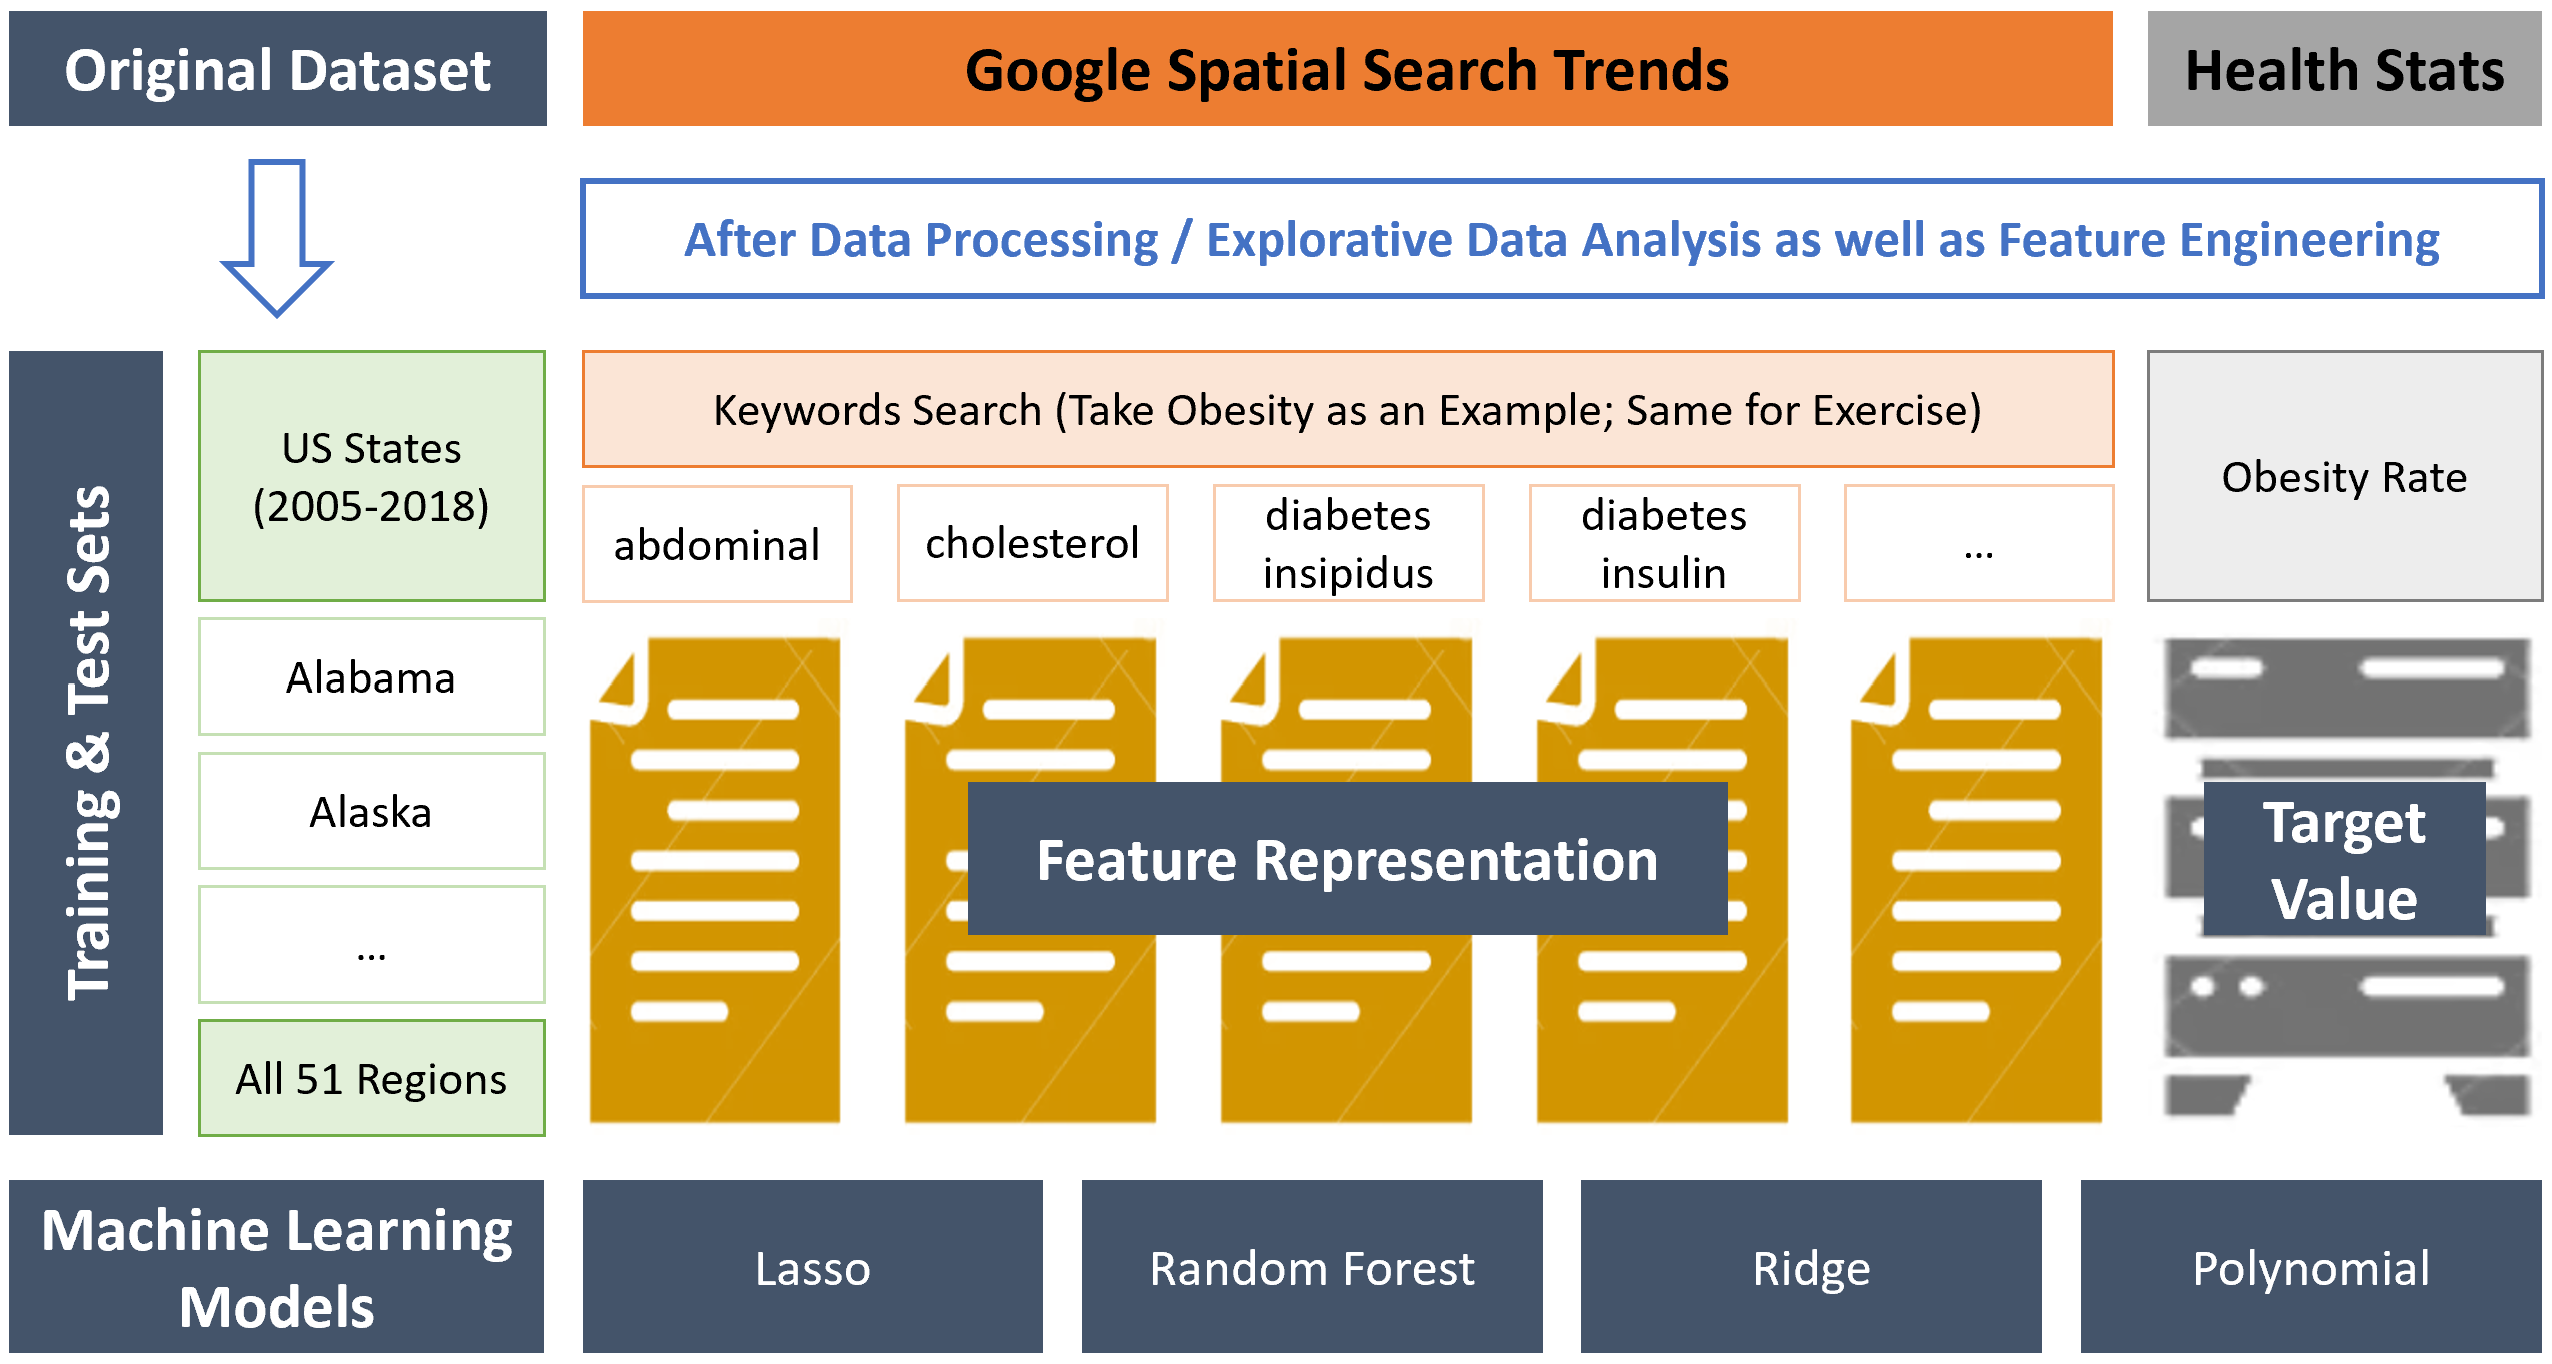

This diagram illustrates the **overarching logic** of this notebook. We start with two primary datasets: Google Search Trends and Health Statistics, which include obesity and exercise rates. Through exploratory data analysis and feature engineering, we aim to create a refined dataset. This dataset will feature **keyword occurrences** as the **feature representations**, and the **obesity and exercise rates** as the **target values**.

Note that:

*   Our analysis covers 51 regions, including all 50 US states and the District of Columbia (now Washington D.C.). Other regions are ignored and dropped.


*   The timeframe for our study spans from 2005 to 2018. We have excluded the year 2004 from our analysis due to the absence of data for Hawaii; further details on this will be provided in the following section.

*   we have conducted **univariate graphical explorations**, such as **histograms**. These are also included in the next section, as they are closely related to the feature engineering process in order to find underlying patterns within the data and test assumptions with the final aim of finding a model that fits the data well.


Our objective is to train our models using data **from 2005 to 2017** across different states, allowing us to **use search trends for obesity/exercise keywords to predict obesity/exercise rates**. We will then evaluate the performance of our models using the **2018 data**.

Based on the result, we can observe and examine our problem statement: Can search trends related to exercise and obesity effectively predict the actual rates of exercise participation and obesity in the US within a given time period (2005-2018)?

For this purpose, we will employ four different machine learning models: **random forest (*trivial Baseline*)**, **lasso**, , **ridge**, and **polynomial** regression, to train and test our data and then draw our conclusion.

# **2. Feature Engineering with necessary explorative data analysis** #

## 2.1 GET our target variable: "Data_Value" column
1. Specifically, for **Obesity**, our target is the **prevalence rates for obesity for each state**.

The **prevalence rates [Values in Data_Value column]** were computed by surveying people
from each state, and then computing their body-mass index **(BMI)**. If the BMI was
in the “obese” category, the subject was classified as obese. The prevalence
rates (or data value) is basically the percentage of people who were obese from
the population sample.

2. Specifically, for **Exercise**, our target is **the percentage of people who exercise**.

Everyone in the state was asked the following question: In the
past month, did you participate in any physical activities? The data value is
basically **a percentage of people who responded with “Yes”**.

In [ ]:
# get the value for each state, obesity and exercise
obesity_df["Outcome"]=obesity_df["Data_Value"].astype(float) #change datatype to float to do the further calculation
obesity_df.drop(["Data_Value","Sample_Size"],axis=1,inplace=True)
obesity_df
exercise_df["Outcome"]=exercise_df["Data_Value"].astype(float)
exercise_df.drop(["Data_Value","Sample_Size"],axis=1,inplace=True)
exercise_df

,Year,LocationDesc,aerobic exercise,...,workout,yoga,Outcome
0,2004.0,Alabama,43.0,...,78.0,28.0,70.4
1,2004.0,Alaska,0.0,...,75.0,44.0,79.4
2,2004.0,Arizona,25.0,...,76.0,72.0,75.8
3,2004.0,Arkansas,44.0,...,71.0,39.0,73.5
4,2004.0,California,16.0,...,66.0,87.0,77.3
...,...,...,...,...,...,...,...
759,2018.0,Virginia,58.0,...,89.0,49.0,78.1
760,2018.0,Washington,36.0,...,83.0,64.0,82.4
761,2018.0,West Virginia,63.0,...,78.0,32.0,71.8
762,2018.0,Wisconsin,57.0,...,82.0,49.0,78.2


### Drop 2004 year data
Reasons for dropping:

1. Hawaii state **does not** have 2004 data for exercise and obesity [as checked on the last section]

2. 2004 is the **first year** of our dataframe, and we can not predict the previous year data with the future year data

3. Even we drop 2004 year data, we still have 2005-2017 year data for us to train the model, the loss of data is not that much.

3. To make the data be align with each state, we decide to drop 2004 year data.

In [ ]:
# Drop the 2004 year data for exercise and obesity dataframe
obesity_df_new=obesity_df[obesity_df["Year"] != 2004].reset_index()
obesity_df_new=obesity_df_new.drop(["index"],axis=1)
exercise_df_new=exercise_df[exercise_df["Year"] != 2004].reset_index()
exercise_df_new=exercise_df_new.drop(["index"],axis=1)
# change the datatype of year column to be integer
exercise_df_new.Year=exercise_df_new.Year.astype(int)
obesity_df_new.Year=obesity_df_new.Year.astype(int)
#sample output
obesity_df_new

,Year,LocationDesc,abdominal,...,weighing,weight loss,Outcome
0,2005,Alabama,88.0,...,25.0,90.0,28.9
1,2005,Alaska,40.0,...,56.0,73.0,27.4
2,2005,Arizona,57.0,...,31.0,65.0,21.1
3,2005,Arkansas,63.0,...,38.0,100.0,28.0
4,2005,California,46.0,...,43.0,53.0,22.7
...,...,...,...,...,...,...,...
709,2018,Virginia,75.0,...,80.0,81.0,30.4
710,2018,Washington,68.0,...,62.0,73.0,28.7
711,2018,West Virginia,100.0,...,74.0,97.0,39.5
712,2018,Wisconsin,76.0,...,70.0,71.0,32.0


### Divide by 100 for the target [avoid misunderstanding of the unit of the target]


In [ ]:
exercise_df_new.Outcome=exercise_df_new.Outcome/100
obesity_df_new.Outcome=obesity_df_new.Outcome/100
# sample output
obesity_df_new

,Year,LocationDesc,abdominal,...,weighing,weight loss,Outcome
0,2005,Alabama,88.0,...,25.0,90.0,0.289
1,2005,Alaska,40.0,...,56.0,73.0,0.274
2,2005,Arizona,57.0,...,31.0,65.0,0.211
3,2005,Arkansas,63.0,...,38.0,100.0,0.280
4,2005,California,46.0,...,43.0,53.0,0.227
...,...,...,...,...,...,...,...
709,2018,Virginia,75.0,...,80.0,81.0,0.304
710,2018,Washington,68.0,...,62.0,73.0,0.287
711,2018,West Virginia,100.0,...,74.0,97.0,0.395
712,2018,Wisconsin,76.0,...,70.0,71.0,0.320


### ploting features in exercise and obesity to observe the distribution of features

Reasons to do this:

1. Have a intuitive sense of features distribution

2. Observe data to see what kind of features should be drop afterwards

**The interpretation of each histogram**
1. The x-axis is the search quantity for the keyword, e.g "20" in the x-axis means the keyword is searched for 20 times

2. The y-axis is the count [number of rows] of the search quantity equals to value x-axis. [Each row contains keywords‘ search quantity per state per year]

3. The sum of columns in the histogram for each subplots is the same and is equal to 51*15.

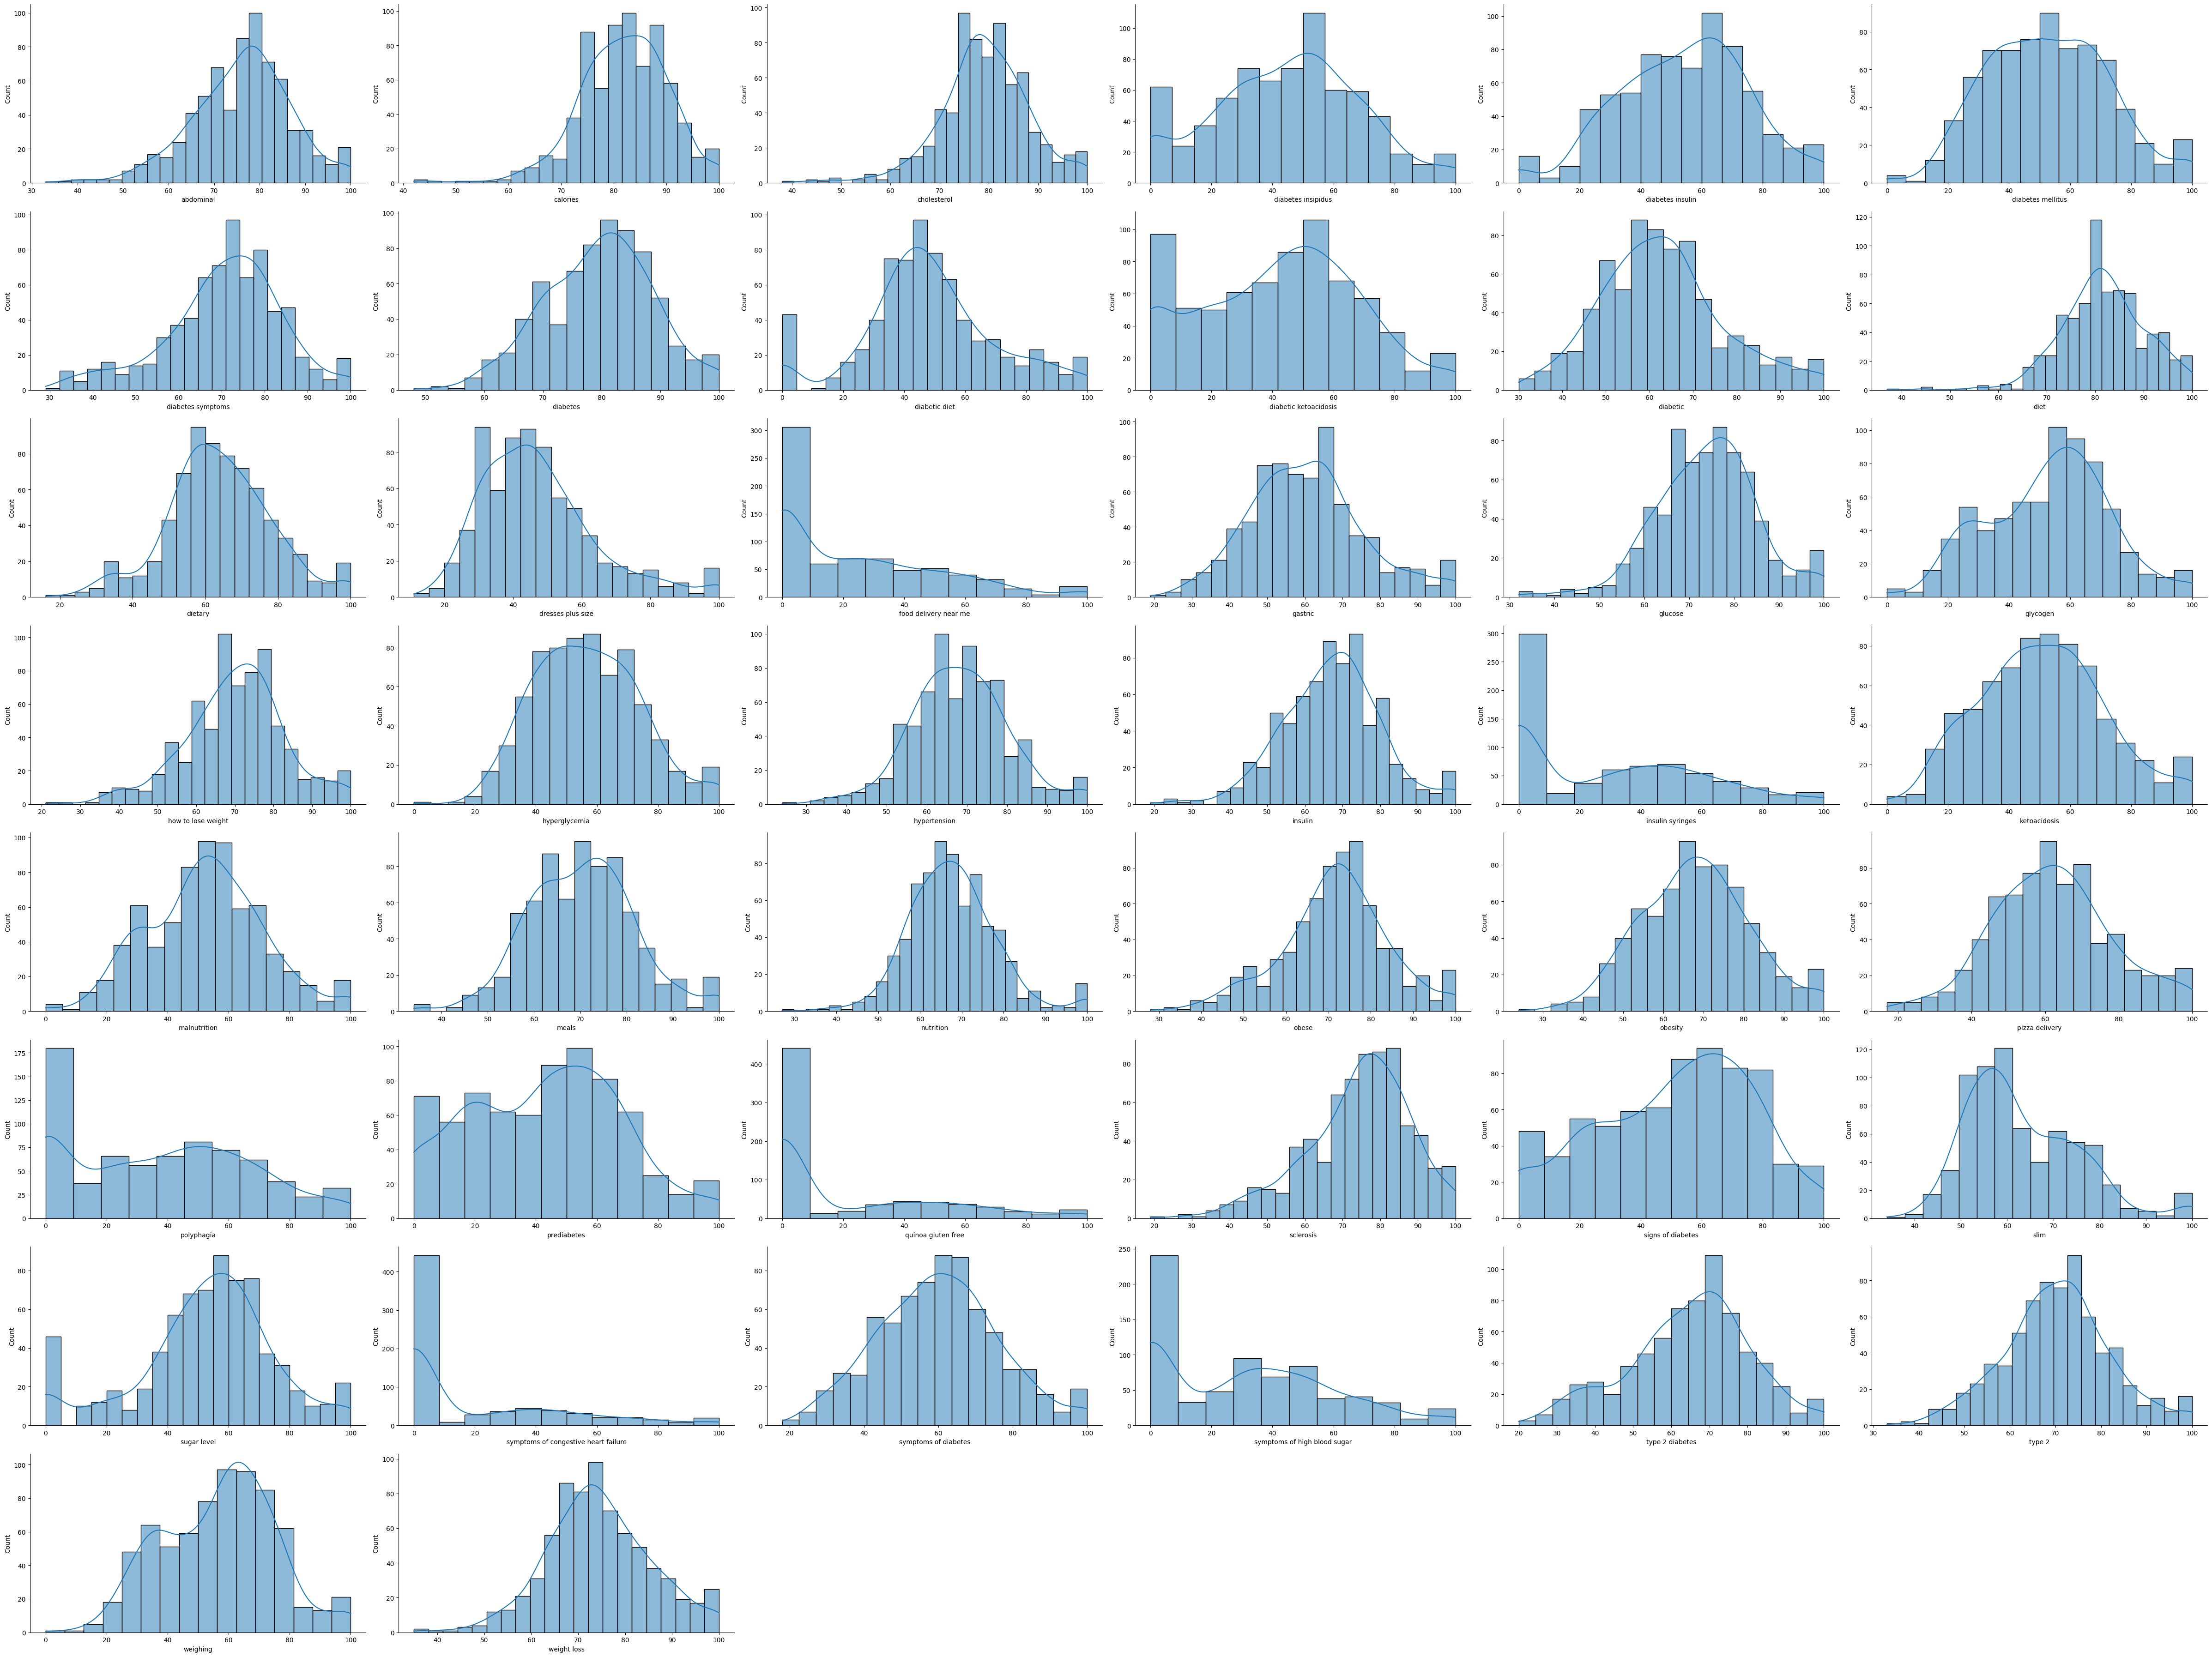

In [ ]:
# # Plot histograms with kernel density estimate for the features
# Obesity features
plt.figure(figsize=(48, 36))
for i in range(2,46,1):
  plt.subplot(8, 6, i -1)  # size and position for subplot
  sns.histplot(obesity_df_new.iloc[:, i], kde=True)  # Histogram with KDE.
  plt.xlabel(obesity_df_new.columns[i])  # Set x-axis label.
  plt.ylabel("Count")  # Set y-axis label.
  sns.despine()  # Remove top and right spines
plt.tight_layout()
plt.show()

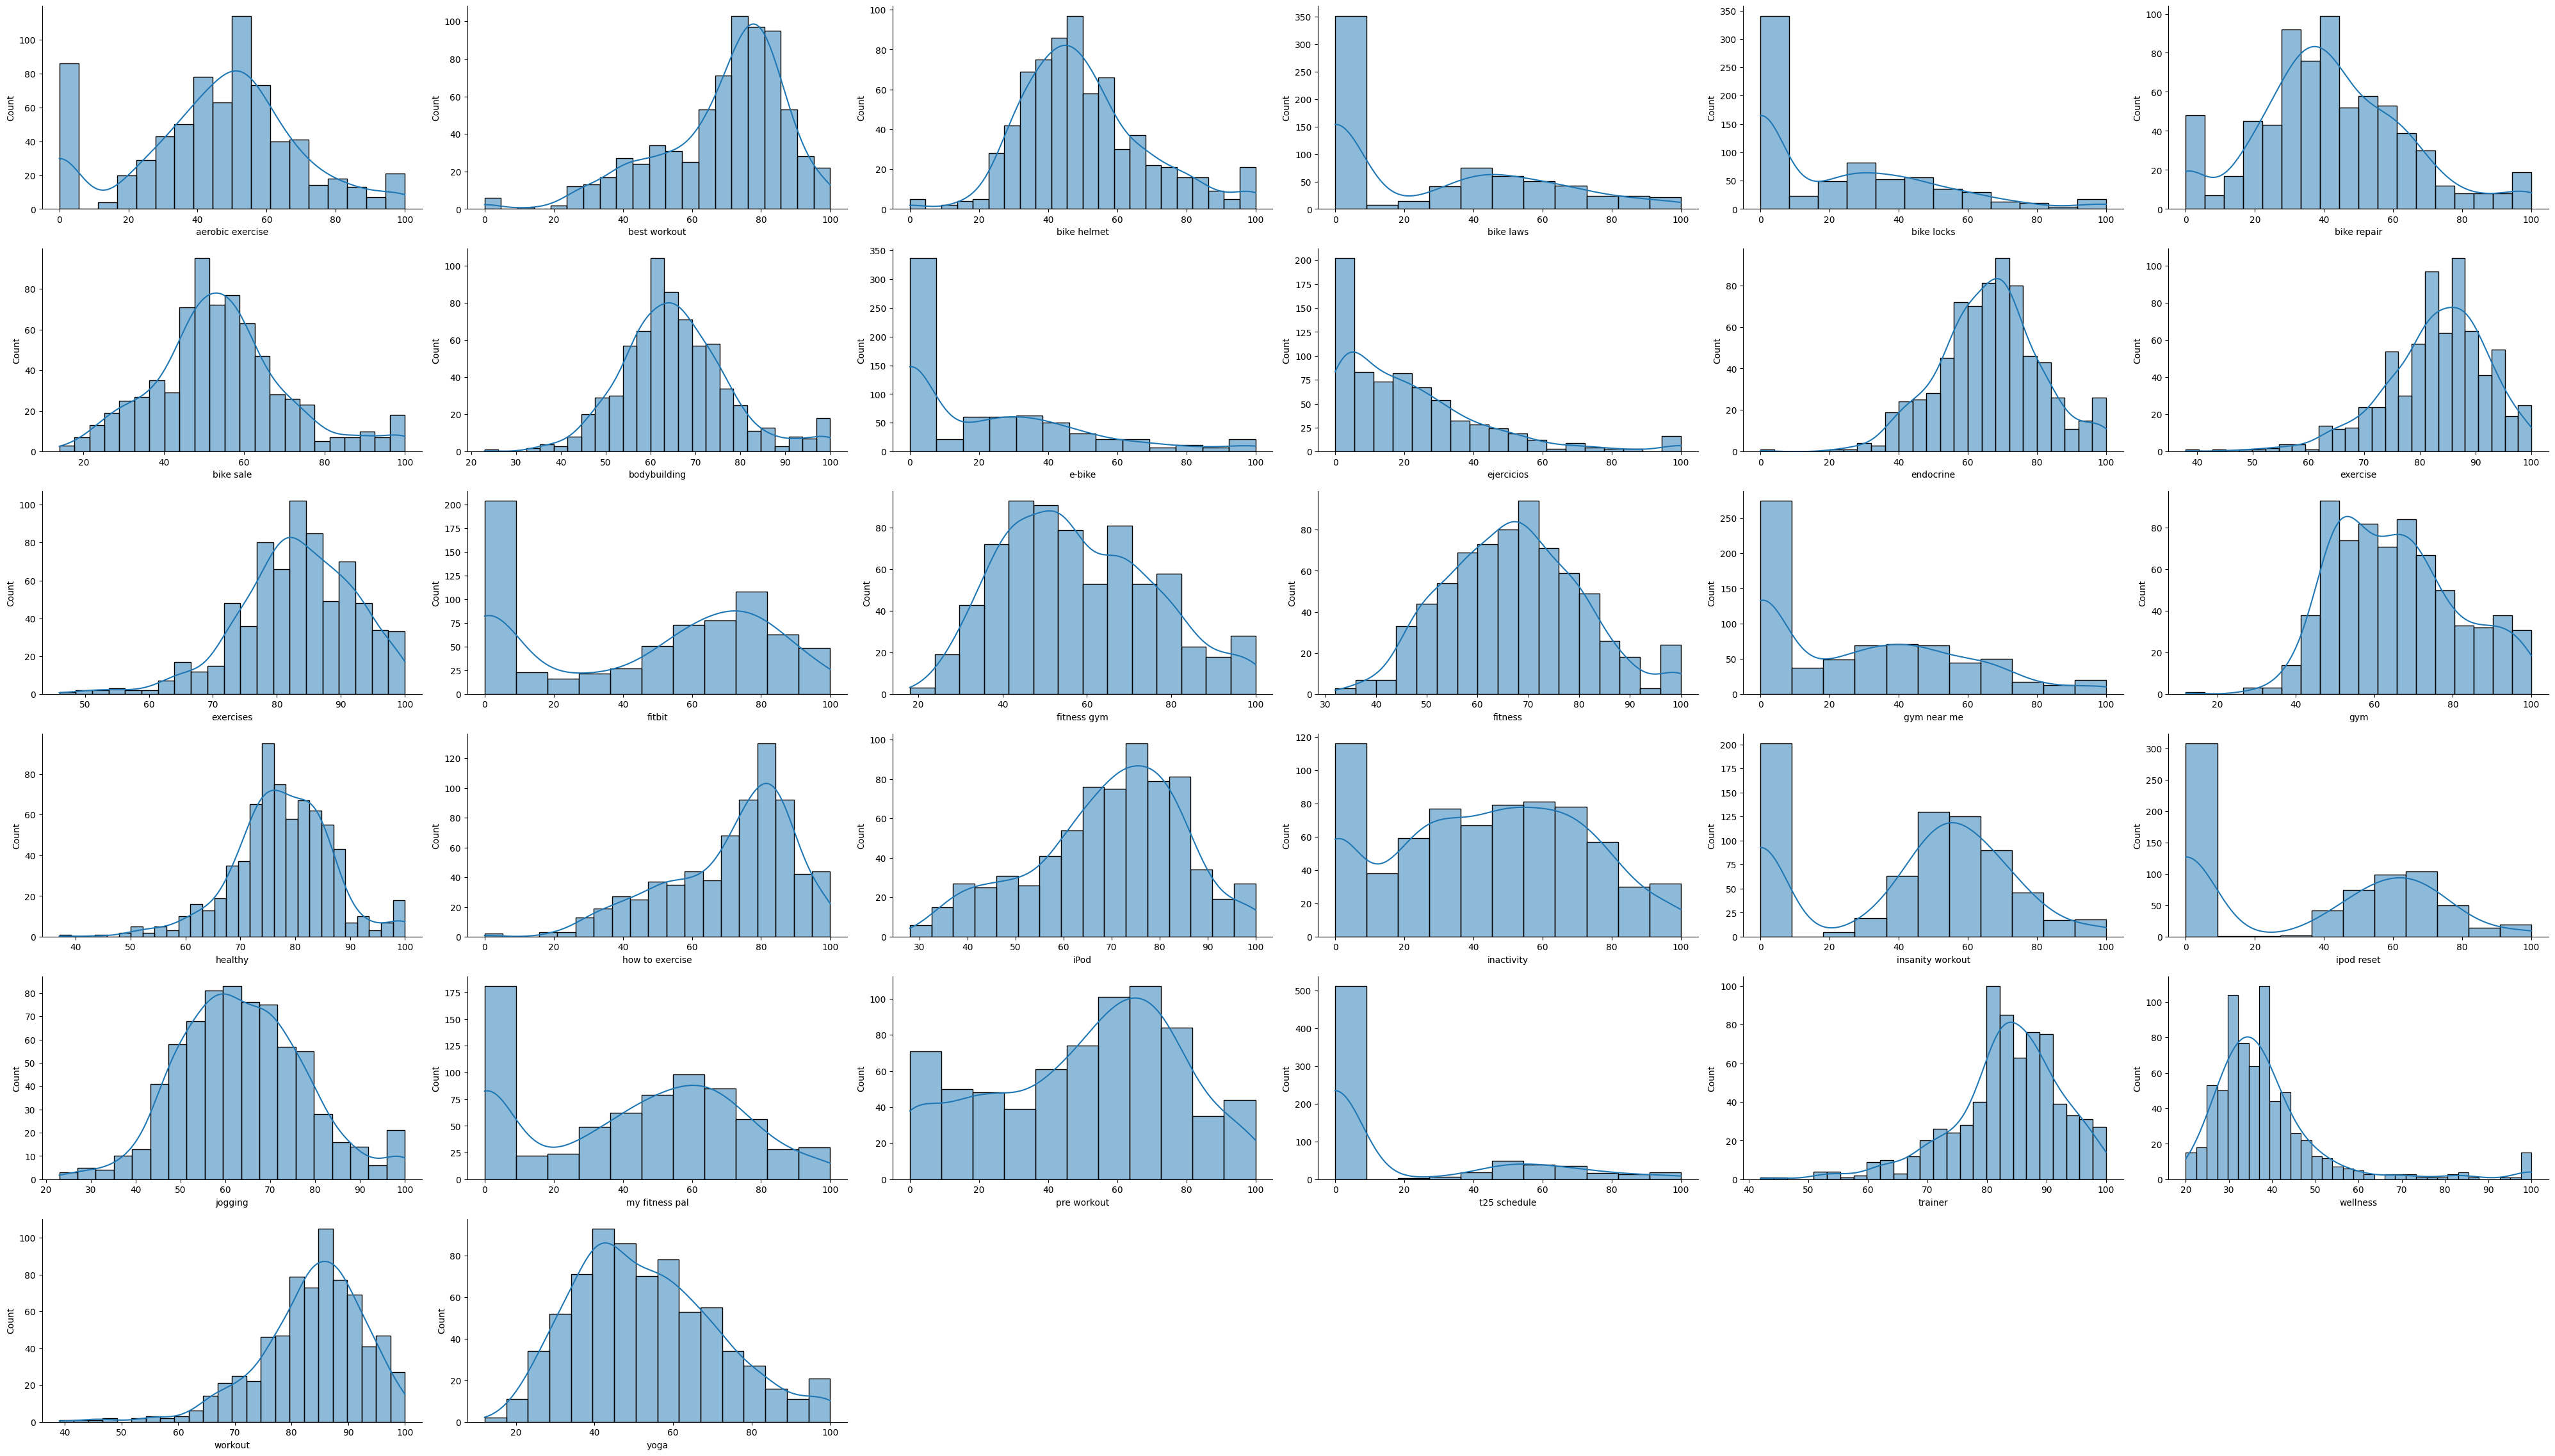

In [ ]:
# This is for exercise
plt.figure(figsize=(40, 30))
for i in range(2,34,1):
  plt.subplot(8, 6, i -1)  # size and position of subplot
  sns.histplot(exercise_df_new.iloc[:, i], kde=True)  # Histogram with KDE.
  plt.xlabel(exercise_df_new.columns[i])  # Set x-axis label.
  plt.ylabel("Count")  # Set y-axis label.
  sns.despine()  # Remove top and right spines
plt.tight_layout()
plt.show()

### After plotting, get the features that should be dropped

Criteria to be dropped:

The distribution is kind of imbalanced, including many 0 values, which may not that predictive for further prediction

In [ ]:
# variable for storing the features to drop, the dropping list is hard-coded
extra_drop_ex=["bike laws","bike locks","e-bike","gym near me","insanity workout","ipod reset","t25 schedule"]
extra_drop_obesity=['diabetic ketoacidosis','food delivery near me','insulin syringes', 'polyphagia', 'quinoa gluten free','symptoms of congestive heart failure', 'symptoms of high blood sugar']

## 2.2 Get the train+validation and test dataset

Our goal is to use the machine learning model to predict the outcome in 2018 and then examine the problem statement, so our test dataset is data of 2018, and train+validation dataset is data from 2005-2017

In [ ]:
test_exercise_df=exercise_df_new[exercise_df_new["Year"]==2018]
test_exercise_df
test_obesity_df=obesity_df_new[obesity_df_new["Year"]==2018]
test_obesity_df
train_exercise_df_full=exercise_df_new[exercise_df_new["Year"]!=2018]
train_obesity_df_full=obesity_df_new[obesity_df_new["Year"]!=2018]

### Correlation test for each feature with our target value

Simply based on the observation of the distribution data is not that rigorous, therefore we decided to **do a correlation test to filter out the features which are not significantly correlated with our target**.

p-value Here we set is 0.05, and we will **drop the features whose p-value is larger than 0.05**

In [ ]:
from scipy.stats import pearsonr
correlation_results = {} # store correlation result
feature_ex_drop=[] # store features of exercise which should drop
feature_obesity_drop=[] # store features of obesity which should drop
print("correlation with obesity keywords")
# First do the test for obesity
for feature in obesity_keywords:
    # calculate Pearson correlation coefficient and p-value
    correlation_coefficient, p_value = pearsonr(train_obesity_df_full[feature], train_obesity_df_full["Outcome"])

    # store output
    correlation_results[feature] = {'p_value': p_value,'correlation_coefficient': correlation_coefficient}

# # append features need to be dropped
for feature, results in correlation_results.items():
    # print(f"Feature: {feature}")
    # print(f"Pearson Correlation Coefficient: {results['correlation_coefficient']}")
    # print(f"P-value: {results['p_value']}")
    if results['p_value'] >= 0.05:
      # print("Correlation is not statistically significant.")

      feature_obesity_drop.append(feature)
print("\n")
# print the table for p-value & coefficients
frame_cof=pd.DataFrame(correlation_results).T
frame_cof["temp-sort"]=frame_cof["correlation_coefficient"].abs()
frame_cof=frame_cof.sort_values(by=["p_value","temp-sort"],ascending=[True,False])
frame_cof=frame_cof.drop(["temp-sort"],axis=1)
print(frame_cof)
frame_cof.to_csv('/content/drive/MyDrive/NYUSH study/Fall 2023/applied data science/sorted_obesity_44*3.csv')

# similar process for exercise
correlation_results = {}
print("correlation with exercise keywords")
for feature in exercise_keywords:
    # calculate Pearson correlation coefficient and p-value
    correlation_coefficient, p_value = pearsonr(train_exercise_df_full[feature], train_exercise_df_full["Outcome"])

    # store output
    correlation_results[feature] = {'correlation_coefficient': correlation_coefficient, 'p_value': p_value}

# append features need to be dropped
for feature, results in correlation_results.items():
    # print(f"Feature: {feature}")
    # print(f"Pearson Correlation Coefficient: {results['correlation_coefficient']}")
    # print(f"P-value: {results['p_value']}")
    if results['p_value'] >= 0.05:
      # print("Correlation is not statistically significant.")

      feature_ex_drop.append(feature)
print("\n")
# print the table for p-value & coefficients
frame_cof=pd.DataFrame(correlation_results).T
frame_cof["temp-sort"]=frame_cof["correlation_coefficient"].abs()
frame_cof=frame_cof.sort_values(by=["p_value","temp-sort"],ascending=[True,False])
frame_cof=frame_cof.drop(["temp-sort"],axis=1)
print(frame_cof)
frame_cof.to_csv('/content/drive/MyDrive/NYUSH study/Fall 2023/applied data science/sorted_ex_row*3.csv')
print(feature_obesity_drop,len(feature_obesity_drop))
print(feature_ex_drop,len(feature_ex_drop))

correlation with obesity keywords


                                            p_value  correlation_coefficient
diabetic                              2.519061e-103                 0.711372
weight loss                            4.589714e-93                 0.685206
how to lose weight                     3.003942e-82                 0.654268
diabetic diet                          6.143323e-77                 0.637617
gastric                                2.613483e-72                 0.622214
diabetes                               3.415400e-58                 0.569206
diet                                   5.518618e-57                 0.564179
hypertension                           1.098665e-54                 0.554371
dresses plus size                      2.824691e-52                 0.543728
abdominal                              2.434826e-49                 0.530227
insulin                                1.017699e-47                 0.522501
symptoms of high blood sugar           2

### Drop the corresponding features
1. First drop features based on correlation test for test and train+validation dataset

2. Then drop features based on distribution for test and train+validation dataset

3. Similar process for exercise and obeisty

In [ ]:
# drop feature based on correlation test
# For exercise
test_exercise_df=test_exercise_df.drop(feature_ex_drop,axis=1)
train_exercise_df_full=train_exercise_df_full.drop(feature_ex_drop,axis=1)
print(train_exercise_df_full.columns)
# For obesity
test_obesity_df=test_obesity_df.drop(feature_obesity_drop,axis=1)
train_obesity_df_full=train_obesity_df_full.drop(feature_obesity_drop,axis=1)
print(train_obesity_df_full.columns)
test_obesity_df.head()

Index(['Year', 'LocationDesc', 'aerobic exercise', 'best workout',
       'bike helmet', 'bike laws', 'bike locks', 'bike repair', 'bike sale',
       'bodybuilding', 'e-bike', 'endocrine', 'exercise', 'exercises',
       'fitness gym', 'fitness', 'gym near me', 'gym', 'healthy',
       'how to exercise', 'iPod', 'insanity workout', 'ipod reset',
       'pre workout', 't25 schedule', 'wellness', 'workout', 'yoga',
       'Outcome'],
      dtype='object')
Index(['Year', 'LocationDesc', 'abdominal', 'cholesterol',
       'diabetes insipidus', 'diabetes insulin', 'diabetes mellitus',
       'diabetes symptoms', 'diabetes', 'diabetic diet',
       'diabetic ketoacidosis', 'diabetic', 'diet', 'dietary',
       'dresses plus size', 'food delivery near me', 'gastric', 'glucose',
       'glycogen', 'how to lose weight', 'hyperglycemia', 'hypertension',
       'insulin', 'insulin syringes', 'ketoacidosis', 'malnutrition', 'meals',
       'obese', 'obesity', 'pizza delivery', 'polyphagia', 'pred

,Year,LocationDesc,abdominal,...,weighing,weight loss,Outcome
663,2018,Alabama,88.0,...,75.0,96.0,0.362
664,2018,Alaska,82.0,...,87.0,68.0,0.295
665,2018,Arizona,75.0,...,63.0,84.0,0.295
666,2018,Arkansas,89.0,...,91.0,87.0,0.371
667,2018,California,63.0,...,72.0,65.0,0.258


In [ ]:
# drop features based on distribution
# exercise
test_exercise_df=test_exercise_df.drop(extra_drop_ex,axis=1)
train_exercise_df_full=train_exercise_df_full.drop(extra_drop_ex,axis=1)
print(train_exercise_df_full.columns)
# obesity
test_obesity_df=test_obesity_df.drop(extra_drop_obesity,axis=1)
train_obesity_df_full=train_obesity_df_full.drop(extra_drop_obesity,axis=1)
print(train_obesity_df_full.columns)
test_obesity_df.head()

Index(['Year', 'LocationDesc', 'aerobic exercise', 'best workout',
       'bike helmet', 'bike repair', 'bike sale', 'bodybuilding', 'endocrine',
       'exercise', 'exercises', 'fitness gym', 'fitness', 'gym', 'healthy',
       'how to exercise', 'iPod', 'pre workout', 'wellness', 'workout', 'yoga',
       'Outcome'],
      dtype='object')
Index(['Year', 'LocationDesc', 'abdominal', 'cholesterol',
       'diabetes insipidus', 'diabetes insulin', 'diabetes mellitus',
       'diabetes symptoms', 'diabetes', 'diabetic diet', 'diabetic', 'diet',
       'dietary', 'dresses plus size', 'gastric', 'glucose', 'glycogen',
       'how to lose weight', 'hyperglycemia', 'hypertension', 'insulin',
       'ketoacidosis', 'malnutrition', 'meals', 'obese', 'obesity',
       'pizza delivery', 'prediabetes', 'sclerosis', 'signs of diabetes',
       'slim', 'sugar level', 'symptoms of diabetes', 'type 2 diabetes',
       'type 2', 'weighing', 'weight loss', 'Outcome'],
      dtype='object')


,Year,LocationDesc,abdominal,...,weighing,weight loss,Outcome
663,2018,Alabama,88.0,...,75.0,96.0,0.362
664,2018,Alaska,82.0,...,87.0,68.0,0.295
665,2018,Arizona,75.0,...,63.0,84.0,0.295
666,2018,Arkansas,89.0,...,91.0,87.0,0.371
667,2018,California,63.0,...,72.0,65.0,0.258


## 2.3 Split train and validation dataset & Normalize data through standardscaler

### Exercise part

In [ ]:
# train validation for exercise
x_exercise = train_exercise_df_full.drop(["Year","Outcome"], axis = 1)
x_exercise=pd.get_dummies(x_exercise,columns=["LocationDesc"]) # use one-hot encoding to get the state information, state information is important for prediction
# get the outcome/target
y_exercise=train_exercise_df_full["Outcome"]
# split for train and validation
x_train_ex,x_val_ex,y_train_ex,y_val_ex=train_test_split(x_exercise,y_exercise,random_state=0)

In [ ]:
# normalize
scaler=StandardScaler()
x_train_ex_scaled=scaler.fit_transform(x_train_ex)
x_val_ex_scaled = scaler.transform(x_val_ex)

In [ ]:
x_test_ex = test_exercise_df.drop(["Year",'Outcome'], axis = 1)
x_test_ex=pd.get_dummies(x_test_ex,columns=["LocationDesc"]) # use one-hot encoding to get the state information, state information is important for prediction
x_test_ex
# scale it through standardscaler as well
x_test_ex_scaled = scaler.transform(x_test_ex)
x_test_ex_scaled
y_test_ex=test_exercise_df["Outcome"]

### obesity part

In [ ]:
# for obesity
x_obesity = train_obesity_df_full.drop(["Year","Outcome"], axis = 1)
x_obesity=pd.get_dummies(x_obesity,columns=["LocationDesc"]) # use one-hot encoding to get the state information, state information is important for prediction
# get the outcome/target
y_obesity=train_obesity_df_full["Outcome"]
# split for train and validation
x_train_obesity,x_val_obesity,y_train_obesity,y_val_obesity=train_test_split(x_obesity,y_obesity,random_state=0)

In [ ]:
scaler=StandardScaler()
x_train_obesity_scaled=scaler.fit_transform(x_train_obesity)
x_val_obesity_scaled = scaler.transform(x_val_obesity)

In [ ]:
x_test_obesity = test_obesity_df.drop(["Year",'Outcome'], axis = 1)
x_test_obesity=pd.get_dummies(x_test_obesity,columns=["LocationDesc"]) # get state information similar to training set
x_test_obesity
# scale it through standardscaler as well
x_test_obesity_scaled = scaler.transform(x_test_obesity)
x_test_obesity_scaled
y_test_obesity=test_obesity_df["Outcome"] # 假装没有这个outcome，然后最后看model的表现

In [ ]:
print(x_train_obesity_scaled) # sample output

[[ 0.04330629  0.25708362  0.90135052 ... -0.11952286 -0.14329648
  -0.14329648]
 [ 0.23377729  1.44014434 -0.64568464 ... -0.11952286 -0.14329648
  -0.14329648]
 [ 1.75754536  1.87034823  0.10692706 ... -0.11952286 -0.14329648
  -0.14329648]
 ...
 [ 0.70995482 -0.9259771  -0.77111992 ... -0.11952286 -0.14329648
  -0.14329648]
 [ 0.70995482  1.22504239  1.06859756 ... -0.11952286 -0.14329648
  -0.14329648]
 [ 0.51948381 -0.17312028  0.52504467 ... -0.11952286  6.97853853
  -0.14329648]]


# **3. ML Models Prediction & Model Comparison** #

### *3.1 Random Forest Model [trivial baseline]* ###

Random Forest Model is good at handling large datasets with high dimensionality and is robust against overfitting, and in some literatures, random forest is used for training the dataset, which makes it valid to be our baseline model.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


#-----------Exercise------------
model = RandomForestRegressor(n_estimators=100)

# Train the model
model.fit(x_train_ex_scaled, y_train_ex)

# Validate the model
val_predictions = model.predict(x_val_ex_scaled)
val_mse = mean_squared_error(y_val_ex, val_predictions)
val_mae=mean_absolute_error(y_val_ex,val_predictions)

print(f"Validation MSE: {val_mse}")
print(f"Validation MAE: {val_mae}")

print(f"Validation R^2: {r2_score(y_val_ex, val_predictions)}")

# Test the model
test_predictions = model.predict(x_test_ex_scaled)
test_mse = mean_squared_error(y_test_ex, test_predictions)
test_mae=mean_absolute_error(y_test_ex,test_predictions)
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Test R^2: {r2_score(y_test_ex, test_predictions)}")


Validation MSE: 0.0005877935289156617
Validation MAE: 0.018969759036144573
Validation R^2: 0.6685471945400011
Test MSE: 0.0008169567941176474
Test MAE: 0.023823725490196065
Test R^2: 0.4396827324089396


In [ ]:
#-----------Obesity------------
model = RandomForestRegressor(n_estimators=100)

# Train the model
model.fit(x_train_obesity_scaled, y_train_obesity)

# Validate the model
val_predictions = model.predict(x_val_obesity_scaled)
val_mse = mean_squared_error(y_val_obesity, val_predictions)
val_mae=mean_absolute_error(y_val_obesity,val_predictions)

print(f"Validation MSE: {val_mse}")
print(f"Validation MAE: {val_mae}")

print(f"Validation R^2: {r2_score(y_val_obesity, val_predictions)}")

# Test the model
test_predictions = model.predict(x_test_obesity_scaled)
test_mse = mean_squared_error(y_test_obesity, test_predictions)
test_mae=mean_absolute_error(y_test_obesity,test_predictions)
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Test R^2: {r2_score(y_test_obesity, test_predictions)}")

Validation MSE: 0.0004053569391566266
Validation MAE: 0.016204879518072295
Validation R^2: 0.7010281348079093
Test MSE: 0.0005140786254901962
Test MAE: 0.018615098039215704
Test R^2: 0.6543848893767796


The Mean Squared and Mean Absolute Error on the validation set is quite low, indicating that the model's predictions are close to the actual values, with a small average squared/absolute error. For Exercise rate, the R squared value on the test set is significantly lower than on the validation set. An R² of approximately 0.43 suggests that the model explains about 43% of the variance in the test data, which is a moderate level of predictive accuracy. For Obesity rate, the R-squared value of 0.64 shows a moderate level of predictive accuracy, indicating that the model explains around 64% of the variance in the test data.

### *3.2 Lasso Model* ###

Lasso regression is known for its ability to perform feature selection. It can shrink the coefficients of less important features to zero, effectively removing them from the model. This is particularly useful in scenarios with a large number of features, as it simplifies the model and avoids overfitting. We added the regularization parameter alpha to help avoid overfitting by penalizing larger coefficients. And We employ GridSearchCV to find the optimal value of the alpha parameter.

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

#-----------Exercise------------

parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso = Lasso()
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)

lasso_regressor.fit(x_train_ex_scaled, y_train_ex)

print("Best parameters:", lasso_regressor.best_params_)
best_lasso_model = lasso_regressor.best_estimator_

val_predictions = best_lasso_model.predict(x_val_ex_scaled)
val_mse = mean_squared_error(y_val_ex, val_predictions)
val_mae=mean_absolute_error(y_val_ex,val_predictions)
print(f"Validation MSE: {val_mse}")
print(f"Validation MAE: {val_mae}")
print(f"Validation R^2: {r2_score(y_val_ex, val_predictions)}")

test_predictions = best_lasso_model.predict(x_test_ex_scaled)
test_mse = mean_squared_error(y_test_ex, test_predictions)
test_mae=mean_absolute_error(y_test_ex, test_predictions)
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Test R^2: {r2_score(y_test_ex, test_predictions)}")


Best parameters: {'alpha': 0.001}
Validation MSE: 0.000493649233516855
Validation MAE: 0.017328829759342537
Validation R^2: 0.7216345275794682
Test MSE: 0.0006839773800264297
Test MAE: 0.02157552724706398
Test R^2: 0.5308878762867457


In [ ]:
#-----------Obesity------------
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso = Lasso()
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)

lasso_regressor.fit(x_train_obesity_scaled, y_train_obesity)

print("Best parameters:", lasso_regressor.best_params_)
best_lasso_model = lasso_regressor.best_estimator_

val_predictions = best_lasso_model.predict(x_val_obesity_scaled)
val_mse = mean_squared_error(y_val_obesity, val_predictions)
val_mae=mean_absolute_error(y_val_obesity,val_predictions)

print(f"Validation MSE: {val_mse}")
print(f"Validation MAE: {val_mae}")
print(f"Validation R^2: {r2_score(y_val_obesity, val_predictions)}")

test_predictions = best_lasso_model.predict(x_test_obesity_scaled)
test_mse = mean_squared_error(y_test_obesity, test_predictions)
test_mae=mean_absolute_error(y_test_obesity, test_predictions)
print(f"Test MSE: {test_mse}")
print(f"Test MSE: {test_mae}")
print(f"Test R^2: {r2_score(y_test_obesity, test_predictions)}")


Best parameters: {'alpha': 0.001}
Validation MSE: 0.00031682258879373493
Validation MAE: 0.014038505966928242
Validation R^2: 0.766326831597546
Test MSE: 0.0006271293409115647
Test MSE: 0.02073831719492756
Test R^2: 0.5783808822482326


The best alpha parameter found through GridSearchCV is 0.001. This suggests that a very small amount of regularization was optimal for our model, indicating that the underlying model might not benefit much from the shrinkage of coefficients that Lasso provides at higher alpha levels. The low MSE and MAE indicates that, on average, the squared/abusolute difference between the predicted values and the actual values is small. This suggests good predictive accuracy. For both Exercise and Obesity predictions the R² is around 0.55, meaning that around 55% of the variance in the dependent variable is predictable from the independent variables.

### *3.3 Ridge Model* ###


Ridge regression is appreciated for its ability to manage multicollinearity among predictor variables. Ridge regression reduces the size of all coefficients by imposing a penalty on their magnitude through the L2 regularization term.This technique is particularly beneficial when dealing with datasets that have numerous correlated variables, as it helps to prevent overfitting and improve model generalizability.

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score

#-----------Exercise------------

alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_cv_ex = RidgeCV(alphas=alphas, cv=5)
ridge_cv_ex.fit(x_train_ex_scaled, y_train_ex)

# Train the model
y_pred_val_ex = ridge_cv_ex.predict(x_val_ex_scaled)
val_mse_ex = mean_squared_error(y_val_ex, y_pred_val_ex)
val_mae_ex=mean_absolute_error(y_val_ex,y_pred_val_ex)
val_r2_ex = r2_score(y_val_ex, y_pred_val_ex)
print(f"Validation MSE: {val_mse_ex}")
print(f"Validation MAE: {val_mae_ex}")
print(f"Validation R^2: {val_r2_ex}")

# Test the model
y_pred_test_ex = ridge_cv_ex.predict(x_test_ex_scaled)
test_mse_ex = mean_squared_error(y_test_ex, y_pred_test_ex)
test_mae_ex=mean_absolute_error(y_test_ex,y_pred_test_ex)
test_r2_ex = r2_score(y_test_ex, y_pred_test_ex)
print(f"Test MSE: {test_mse_ex}")
print(f"Test MAE: {test_mae_ex}")
print(f"Test R^2: {test_r2_ex}")


Validation MSE: 0.00037117693740435187
Validation MAE: 0.015342244947461775
Validation R^2: 0.7906958291091102
Test MSE: 0.00034635360837354103
Test MAE: 0.01580365666724819
Test R^2: 0.7624502190794932


In [ ]:
#-----------Obesity------------

ridge_cv_obesity = RidgeCV(alphas=alphas, cv=5)
ridge_cv_obesity.fit(x_train_obesity_scaled, y_train_obesity)

# Predict on the validation set and calculate the MSE and R^2
y_pred_val_obesity = ridge_cv_obesity.predict(x_val_obesity_scaled)
val_mse_obesity = mean_squared_error(y_val_obesity, y_pred_val_obesity)
val_mae_obesity=mean_absolute_error(y_val_obesity,y_pred_val_obesity)
val_r2_obesity = r2_score(y_val_obesity, y_pred_val_obesity)
print(f"Obesity Validation MSE: {val_mse_obesity}")
print(f"Obesity Validation MAE: {val_mae_obesity}")

print(f"Obesity Validation R^2: {val_r2_obesity}")

# Predict on the test set and calculate the MSE and R^2
y_pred_test_obesity = ridge_cv_obesity.predict(x_test_obesity_scaled)
test_mse_obesity = mean_squared_error(y_test_obesity, y_pred_test_obesity)
test_mae_obesity=mean_absolute_error(y_test_obesity,y_pred_test_obesity)
test_r2_obesity = r2_score(y_test_obesity, y_pred_test_obesity)
print(f"Obesity Test MSE: {test_mse_obesity}")
print(f"Obesity Test MAE: {test_mae_obesity}")

print(f"Obesity Test R^2: {test_r2_obesity}")


Obesity Validation MSE: 0.00019681750636636896
Obesity Validation MAE: 0.01106914873202435
Obesity Validation R^2: 0.8548368331790834
Obesity Test MSE: 0.0003911671647614097
Obesity Test MAE: 0.015571169593004348
Obesity Test R^2: 0.7370182765481186


### *3.4 Polynomial Model* ###

Polynomial regression extends the linear model by adding extra predictors, obtained by raising each of the original predictors to a power. By including polynomial terms, we can fit a wider range of curvature in the data, allowing for a more flexible model that can capture the intrinsic patterns more effectively. However, the degree of the polynomial is crucial: too high and the model risks overfitting to the training data; too low and it may not capture the complexity of the data. Cross-validation is typically used to select the degree of the polynomial that results in the best balance between bias and variance, fitting the underlying trend in the data without overfitting.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

degrees = [1, 2, 3]
alpha = 1

#-----------Exercise------------
polynomial_models_ex = []
best_degree_ex = None
best_mse_ex = float('inf')
best_mae_ex=float("inf")
best_model_ex = None

for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    model.fit(x_train_ex_scaled, y_train_ex)

    # Validate the model
    y_pred_val_ex = model.predict(x_val_ex_scaled)
    val_mse_ex = mean_squared_error(y_val_ex, y_pred_val_ex)
    val_mae_ex=mean_absolute_error(y_val_ex,y_pred_val_ex)
    val_r2_ex = r2_score(y_val_ex, y_pred_val_ex)

    # Perform cross-validation
    scores = cross_val_score(model, x_val_ex_scaled, y_val_ex, scoring='neg_mean_squared_error', cv=5)
    scores_mae=cross_val_score(model, x_val_ex_scaled, y_val_ex, scoring='neg_mean_absolute_error', cv=5)
    avg_mse = -scores.mean()
    avg_mae=-scores_mae.mean()
    polynomial_models_ex.append((degree, val_mse_ex, val_r2_ex, avg_mse))

    # Check if this model has the best MSE
    if avg_mse < best_mse_ex:
        best_mse_ex = avg_mse
        best_mae_ex= avg_mae
        best_degree_ex = degree
        best_model_ex = model

# Test the best model
y_pred_test_ex = best_model_ex.predict(x_test_ex_scaled)
test_mse_ex = mean_squared_error(y_test_ex, y_pred_test_ex)
test_mae_ex=mean_absolute_error(y_test_ex,y_pred_test_ex)
test_r2_ex = r2_score(y_test_ex, y_pred_test_ex)

print(f"Best degree for exercise dataset: {best_degree_ex}")
print(f"Exercise Validation MSE: {best_mse_ex}")
print(f"Exercise Validation MAE: {best_mae_ex}")

print(f"Exercise Validation R^2: {val_r2_ex}")
print(f"Exercise Test MSE: {test_mse_ex}")
print(f"Exercise Test MAE: {test_mae_ex}")

print(f"Exercise Test R^2: {test_r2_ex}")


Best degree for exercise dataset: 3
Exercise Validation MSE: 0.000648991862649278
Exercise Validation MAE: 0.020390517110090736
Exercise Validation R^2: 0.5451676597639222
Exercise Test MSE: 0.0005546781867396804
Exercise Test MAE: 0.018071686407326017
Exercise Test R^2: 0.6195689071635471


In [ ]:
#-----------Obesity------------
polynomial_models_obesity = []
best_degree_obesity = None
best_mse_obesity = float('inf')
best_mae_obesity=float("inf")
best_model_obesity = None

for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    model.fit(x_train_obesity_scaled, y_train_obesity)

    # Validate the model
    y_pred_val_obesity = model.predict(x_val_obesity_scaled)
    val_mse_obesity = mean_squared_error(y_val_obesity, y_pred_val_obesity)
    val_mae_obesity=mean_absolute_error(y_val_obesity,y_pred_val_obesity)
    val_r2_obesity = r2_score(y_val_obesity, y_pred_val_obesity)

    # Perform cross-validation
    scores = cross_val_score(model, x_val_obesity_scaled, y_val_obesity, scoring='neg_mean_squared_error', cv=5)
    scores_mae=cross_val_score(model, x_val_obesity_scaled, y_val_obesity, scoring='neg_mean_absolute_error', cv=5)
    avg_mse = -scores.mean()
    avg_mae=-scores_mae.mean()
    polynomial_models_obesity.append((degree, val_mse_obesity, val_r2_obesity, avg_mse))

    # Check if this model has the best MSE
    if avg_mse < best_mse_obesity:
        best_mse_obesity = avg_mse
        best_mae_obesity=avg_mae
        best_degree_obesity = degree
        best_model_obesity = model

# Test the best model
y_pred_test_obesity = best_model_obesity.predict(x_test_obesity_scaled)
test_mse_obesity = mean_squared_error(y_test_obesity, y_pred_test_obesity)
test_mae_obesity=mean_absolute_error(y_test_obesity,y_pred_test_obesity)
test_r2_obesity = r2_score(y_test_obesity, y_pred_test_obesity)

print(f"Best degree for obesity dataset: {best_degree_obesity}")
print(f"Obesity Validation MSE: {best_mse_obesity}")
print(f"Obesity Validation MAE: {best_mae_obesity}")

print(f"Obesiity Validation R^2: {val_r2_obesity}")
print(f"Obesity Test MSE: {test_mse_obesity}")
print(f"Obesity Test MAE: {test_mae_obesity}")

print(f"Obesity Test R^2: {test_r2_obesity}")

Best degree for obesity dataset: 1
Obesity Validation MSE: 0.0004043609950960951
Obesity Validation MAE: 0.015376936730962642
Obesiity Validation R^2: 0.8601838966055674
Obesity Test MSE: 0.00035480992374241306
Obesity Test MAE: 0.01507276252232241
Obesity Test R^2: 0.7614612532712877


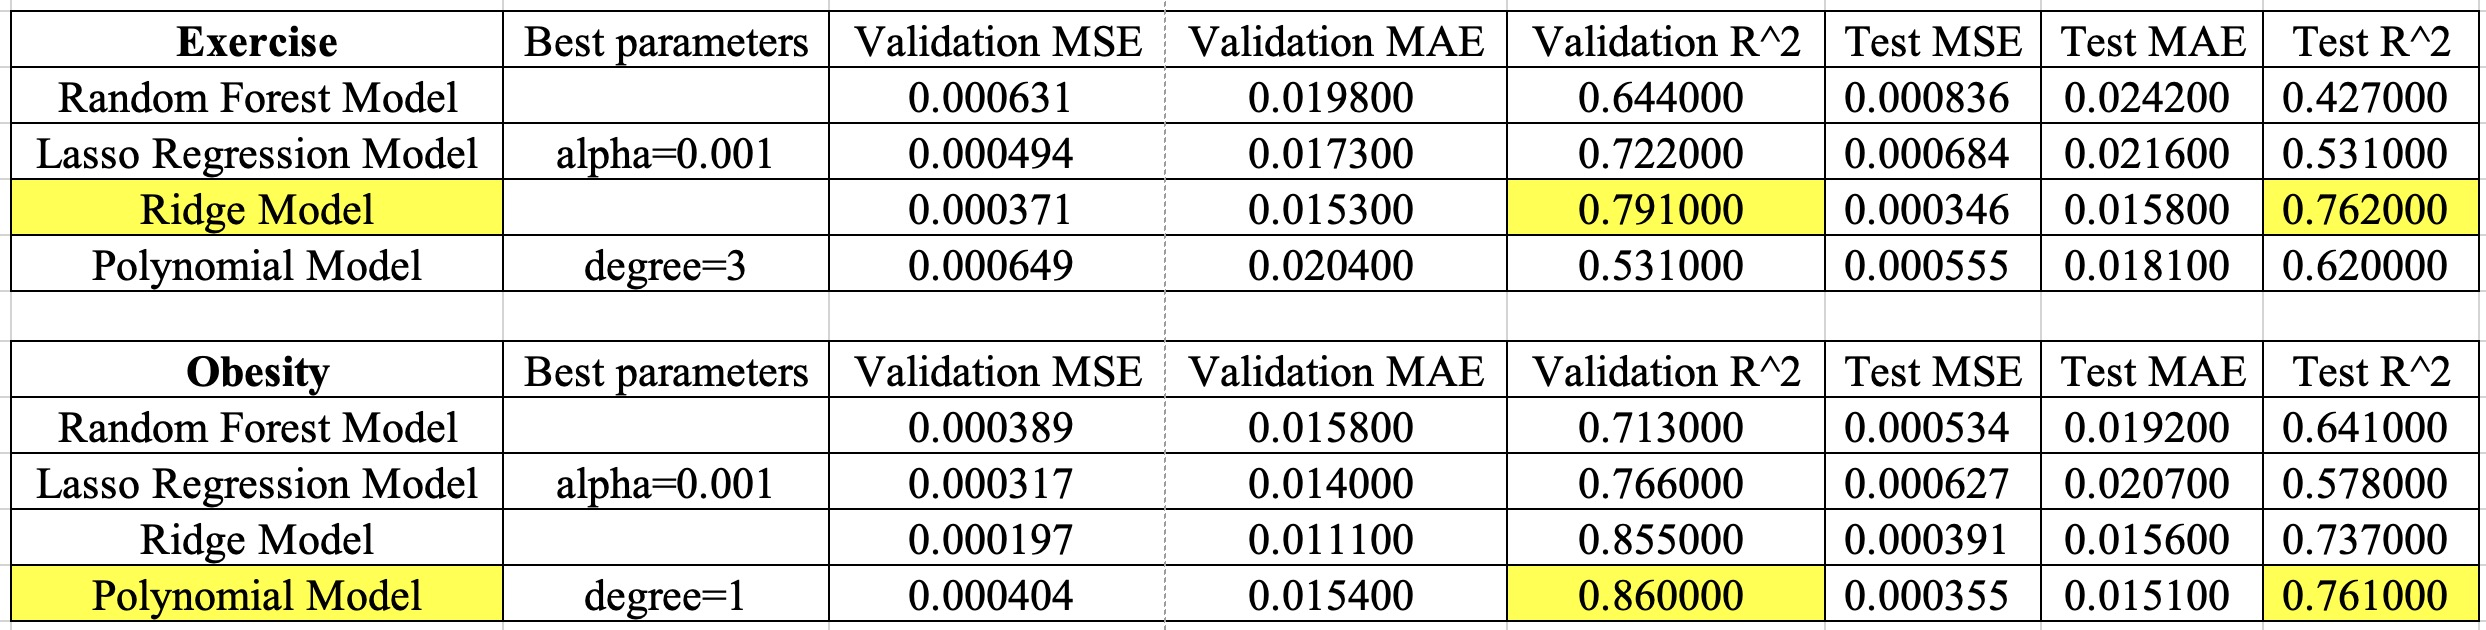

We choose to use the the coefficient of determination (R^2) or Mean Absolute Error (MAE) instead of the Mean Squared Error (MSE) as the primary performance metric for several reasons:

**Robustness to Outliers**: MAE is less sensitive to outliers in the data compared to MSE. MSE gives greater weight to larger/extremely smaller [value are 0.xyz...] errors (since the error terms are squared), which can skew the model performance assessment if outliers are present.

**Error Scale Consistency**: The scale of MAE is consistent with the scale of the original data, allowing errors to be directly compared to the data itself. In contrast, MSE's magnitude is typically larger/extremely smaller than that of the original data due to the squaring operation.

**Reasons for Emphasizing R^2**: The R^2 value measures the model's ability to explain the variability in the data, which can be a great metric when the MAE/MSE does not show big difference.

In summary, R^2 is chosen as the primary performance metric in this project because MAE does not have huge difference between each model and R^2 can indicate the strong relationship between the target and features.



Based on the chart, we can observe that for exercise, all other models perform better than baseline. Ridge Model has highest R^2.

For obesity, we can observe that the Polynomial model and Ridge Model perform better than the baseline, while the lasso is not. Polynomial Model with degree 1 has highest R^2.

**Therefore, based on our analysis, for predicting exercise rates, Ridge Model with alpha=0.001 performs the best while for the Obesity rates, Linear Polynomial [Polynomial Model with degree 1] performs the best.**

# **4. Data Exploration [previous exploration in Milestone 1-2]** #
#### For result in Milestone1, we basically do the data processing, which is integrated and finalized in the first part of our notebook. For clarity, we choose to not put the code of Milestone 1 here.

#### For result in Milestone2, we basically do the data exploration & visualization, which focus on the general situation in the whole US. For clarity of the logic of the code above, we choose to put the code of Milestone 2 here. Since in Milestone2, the data processing will be a little different, we decide to put the whole code and explanation below.



### For data visualization and statistical analysis for the general situation in whole US, our targets are the relationship between obesity/exercise prevalence rate with different gender as well as the relationship between obesity/exercise prevalence rate with the search quantity data.

#### **Obesity prevalence rate:** obesity rate [data_value column]/ total number of people [sample_size column]
#### **Exercise prevalence rate:** exercise rate [data_value column]/ total number of people [sample_size column]

#### The visualized data as well as data for statistical analysis are normalized through **mean normalization method**



#### Code for Data cleaning & processing for general situation of the whole US

In [ ]:
# Obtain the prevalence rates (for overall, male and female; of obesity and exercise) from the Health Statistics dataset,
health_df = pd.read_csv("/content/drive/MyDrive/Applied DS Sean/milestones/preprocessed_data/health_stats.csv")
health_df["Data_Value"] = pd.to_numeric(health_df["Data_Value"], errors="coerce")
health_df["Year"] = health_df["Year"].astype(int)
# Drop unnecessary rows and columns.
col_to_drop = ["Unnamed: 0", "ID", "LocationAbbr", "Low_Confidence_Limit", "High_Confidence_Limit"]
health_df.drop(col_to_drop, axis=1, inplace=True)
row_to_drop = ["All States, DC and Territories (median) **", "All States and DC (median) **"]
condition = ~health_df["LocationDesc"].isin(row_to_drop)
health_df = health_df[condition]
# Deal with missing data by dropping the rows.
nan_rows = health_df[health_df.isna().any(axis=1)].sort_values(by=["LocationDesc", "Stratification", "Year"])
health_df.dropna(inplace=True)
def weighted_average(group):
  d = group["Data_Value"]
  w = group["Sample_Size"]
  return (d * w).sum() / w.sum()
health_df = health_df.groupby(["variable", "Year", "Stratification", "StratificationType"]).apply(weighted_average).reset_index(name="weighted_average")
# Filter rows to create new independent dataframes, for obesity and exercise.
# Then, rename the "weighted_average" into prevalence rate, remove the now-redundant "variable" column, and reset the index.
health_obesity = health_df[health_df["variable"] == "obesity"].copy()
health_exercise = health_df[health_df["variable"] == "exercise"].copy()
health_obesity.rename(columns={"weighted_average": "obesity_rate"}, inplace=True)
health_exercise.rename(columns={"weighted_average": "exercise_rate"}, inplace=True)
health_obesity.drop(columns=["variable"], inplace=True)
health_exercise.drop(columns=["variable"], inplace=True)
health_obesity.reset_index(drop=True, inplace=True)
health_exercise.reset_index(drop=True, inplace=True)
# Divide the datasets by stratification (overall/gender), for both obesity and exercise.
# Filter by "StratificationType", remove the now-redundant "StratificationType" column, and set "Stratification" as the index.
health_obesity_gender = health_obesity[health_obesity["StratificationType"] == "Gender"].copy()
health_obesity_overall = health_obesity[health_obesity["StratificationType"] == "Overall"].copy()
health_obesity_gender.drop(columns=["StratificationType"], inplace=True)
health_obesity_overall.drop(columns=["StratificationType"], inplace=True)
health_obesity_gender.set_index("Stratification", inplace=True)
health_obesity_overall.set_index("Stratification", inplace=True)
health_exercise_gender = health_exercise[health_exercise["StratificationType"] == "Gender"].copy()
health_exercise_overall = health_exercise[health_exercise["StratificationType"] == "Overall"].copy()
health_exercise_gender.drop(columns=["StratificationType"], inplace=True)
health_exercise_overall.drop(columns=["StratificationType"], inplace=True)
health_exercise_gender.set_index("Stratification", inplace=True)
health_exercise_overall.set_index("Stratification", inplace=True)
# Sort by "Year".
order = ["Year", "Stratification"]
health_obesity_gender.sort_values(by=order, inplace=True)
health_obesity_overall.sort_values(by=order, inplace=True)
health_exercise_gender.sort_values(by=order, inplace=True)
health_exercise_overall.sort_values(by=order, inplace=True)

In [ ]:
# Obtain the search quantity (overall; of obesity and exercise) from the Spatial Trends dataset.
spatial_df = pd.read_csv("/content/drive/MyDrive/Applied DS Sean/milestones/preprocessed_data/spatial_trends.csv")
# Select keywords to represent exercise and obesity, respectively.
obesity_list = ["calories", "cholesterol", "diet", "dresses plus size", "food delivery near me", "how to lose weight", "obese", "obesity", "sugar level", "symptoms of diabetes", "symptoms of high blood sugar", "weighing", "weight loss"]
exercise_list = ["aerobic exercise", "best workout", "bodybuilding", "exercise", "exercises", "fitness gym", "fitness", "gym near me", "gym", "how to exercise", "jogging", "workout", "yoga"]
spatial_obesity = spatial_df.iloc[:, 1:3].join(spatial_df[obesity_list])
spatial_exercise = spatial_df.iloc[:, 1:3].join(spatial_df[exercise_list])
# For a given year (2004-2018), for obesity/exercise， respectively, add search appearances FOR ALL SELECTED KEYWORDS and ACROSS ALL GIVEN LOCATIONS.
def sum_spatial(df, header):
  sum_col_df = df.groupby("year")[df.columns[2:]].sum() # Sum within a column
  sum_row_df = sum_col_df.groupby("year").sum() # Sum across columns
  sum_row_df[header] = sum_row_df.sum(axis=1)
  sum_row_df = sum_row_df[header] # Keep only the sum
  result_df = sum_row_df.reset_index()
  return result_df
spatial_obesity = sum_spatial(spatial_obesity, "obesity_search")
spatial_exercise = sum_spatial(spatial_exercise, "exercise_search")
# Merge the prevalence rate (from Health Statistics) and the search quantity (from Spatial Trends) on the years.
health_obesity_df = health_obesity_overall.reset_index()
health_obesity_df.drop("Stratification", axis=1, inplace=True)
health_obesity_df.rename(columns=str.lower, inplace=True)
health_exercise_df = health_exercise_overall.reset_index()
health_exercise_df.drop("Stratification", axis=1, inplace=True)
health_exercise_df.rename(columns=str.lower, inplace=True)
merged_df = health_obesity_df.merge(health_exercise_df, on="year").merge(spatial_obesity, on="year").merge(spatial_exercise, on="year")
merged_df[["obesity_search", "exercise_search"]] = merged_df[["obesity_search", "exercise_search"]].astype(int)
merged_df.set_index("year", inplace=True)

In [ ]:
# Normalize the data by using mean normalization.
def normalize_column(column):
  return (column - column.mean()) / (column.max()-column.min())
health_obesity_gender["obesity_rate_normalized"] = normalize_column(health_obesity_gender["obesity_rate"])
health_exercise_gender["exercise_rate_normalized"] = normalize_column(health_exercise_gender["exercise_rate"])
merged_df = merged_df.apply(normalize_column)
merged_df.columns = [col + "_normalized" for col in merged_df.columns]
# Export the cleaned data files into csv files.
output_directory = "/content/drive/MyDrive/Applied DS Sean/milestones/milestone2/data_for_milestone2/"
# health_obesity_gender.to_csv(output_directory + "health_obesity_gender.csv")
# health_exercise_gender.to_csv(output_directory + "health_exercise_gender.csv")
# merged_df.to_csv(output_directory + "merged_df.csv")

### **4.1 Within the Rate -- Gender Differences**
#### **RQ:** Are there differences in the obesity rate between females and males in the United States from 2004 to 2018?
#### **Hypo:** There is a significant difference in the obesity rate between females and males in the United States from 2004 to 2018.
#### And replicate the above for the **exercise rate.**



#### **4.1 (a) Are There Differences in Obesity Rates between Females and Males?**


We aim to employ error bars as a means to effectively communicate the precision and reliability of data points within the plot, providing a visual representation of the range in which the true value of a data point is likely to reside. To achieve this, we calculated the **standard deviation** independently for obesity and exercise rates among males and females. Subsequently, we utilized **1.96 times the standard deviation** as the error bar range, aligning with the **95% confidence interval**. This value corresponds to the critical point for a two-tailed test at a **5% significance level**.

#### **4.1.1 (a) Descriptive Analysis**

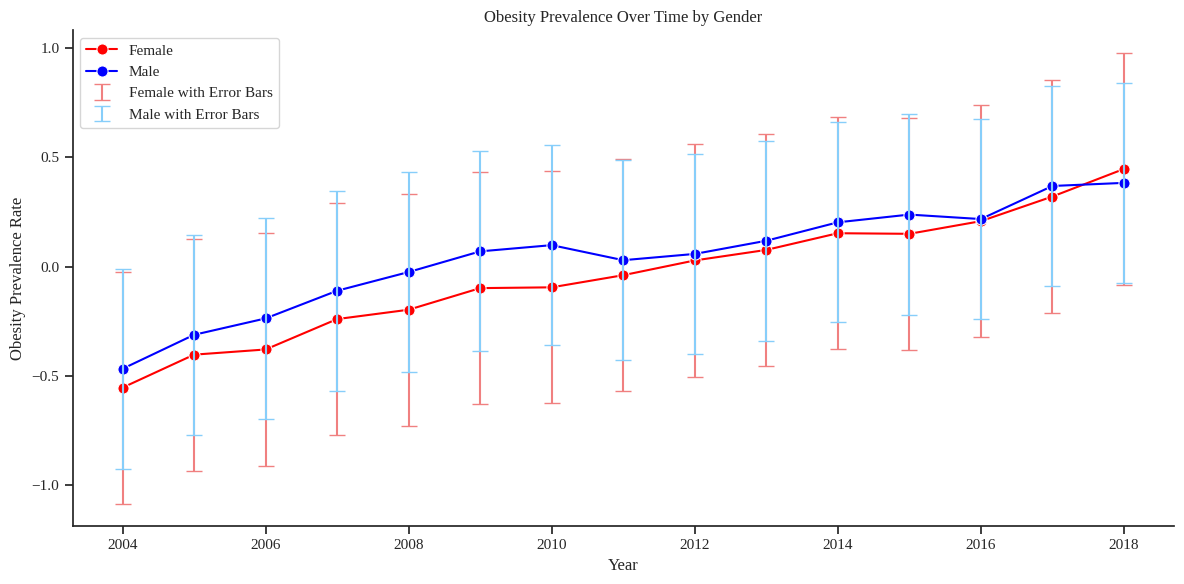

In [ ]:
# Set the style of seaborn
fm.get_font_names()
sns.set(style="ticks", palette='Set2', font='Liberation Serif')

# Create a Seaborn lineplot
plt.figure(figsize=(12, 6))

# Filter the data for males and females
health_obesity_gender_female = health_obesity_gender[health_obesity_gender['Stratification'] == 'Female']
health_obesity_gender_male = health_obesity_gender[health_obesity_gender['Stratification'] == 'Male']
# health_obesity_gender_female = health_obesity_gender.loc['Female']
# health_obesity_gender_male = health_obesity_gender.loc['Male']

# Plot obesity prevalence rate for males in blue and females in red.
sns.lineplot(x='Year', y='obesity_rate_normalized', data=health_obesity_gender_female, marker='o', markersize=8, label='Female', color='red')
sns.lineplot(x='Year', y='obesity_rate_normalized', data=health_obesity_gender_male, marker='o', markersize=8, label='Male', color='blue')

# get the obesity rate data for male and female
obesity_rate_female = health_obesity_gender_female['obesity_rate_normalized']
obesity_rate_male = health_obesity_gender_male['obesity_rate_normalized']

# Calculate the standard deviation
std_dev_female = np.std(obesity_rate_female)
std_dev_male = np.std(obesity_rate_male)

# Assuming error bars with caps based on standard deviation
plt.errorbar(x=health_obesity_gender_female['Year'], y=health_obesity_gender_female['obesity_rate_normalized'],
  yerr=1.96*std_dev_female, fmt='none', color='lightcoral', label='Female with Error Bars', capsize=6)
plt.errorbar(x=health_obesity_gender_male['Year'], y=health_obesity_gender_male['obesity_rate_normalized'],
  yerr=1.96*std_dev_male, fmt='none', color='lightskyblue', label='Male with Error Bars', capsize=6)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Obesity Prevalence Rate')
plt.title('Obesity Prevalence Over Time by Gender')
plt.legend(loc='best')
# Delete the upper and right axis
sns.despine()
plt.tight_layout()
plt.show()

The graphical representation illustrates two distinct lines: a red line denoting females and a blue line for males. Additionally, error bars are depicted, with light blue corresponding to males and pink to females.

It is evident that the obesity prevalence rates among males consistently surpass those among females, with the exception of the year 2018. Within our dataset, the year 2011 emerges as a significant point, particularly notable for the obesity rate among males. Following 2011, the obesity rate for males shows increased variability, with an overall upward trajectory. In contrast, the obesity rate among females has shown a consistent upward trend. What is more, there was a slight decline in the obesity rate among males from 2010 to 2011, after which the disparity between male and female rates has gradually declined.

### **4.1.2 (a) Inferential Analysis**

In [ ]:
#t test obesity rate (male vs. female)

#extract obesity rates for males and females
obesity_rate_male = health_obesity_gender[health_obesity_gender['Stratification'] == 'Male']['obesity_rate_normalized']
obesity_rate_female = health_obesity_gender[health_obesity_gender['Stratification'] == 'Female']['obesity_rate_normalized']

#perform t-test
t_statistic, p_value = stats.ttest_ind(obesity_rate_male, obesity_rate_female)

print(f"T-Statistic: {t_statistic}, P-Value: {p_value}")

T-Statistic: 0.874857218682144, P-Value: 0.38909444762479184


The T-Statistic of `0.875` suggests a small difference between the male and female obesity rates, and the p-value of `0.389` means there's a `38.9%` chance of seeing a difference as large as we observed (or larger) if there were actually no difference between male and female obesity rates.

Since the p-value is greater than the significance threshold of `0.05`, we would not reject the null hypothesis. In other words, the evidence is not strong enough to conclude that there is a statistically significant difference in obesity rates between males and females in your dataset.

### **4.1 (b) Are There Differences in Exercise Rates between Females and Males?**

### **4.1.1 (b) Descriptive Analysis**

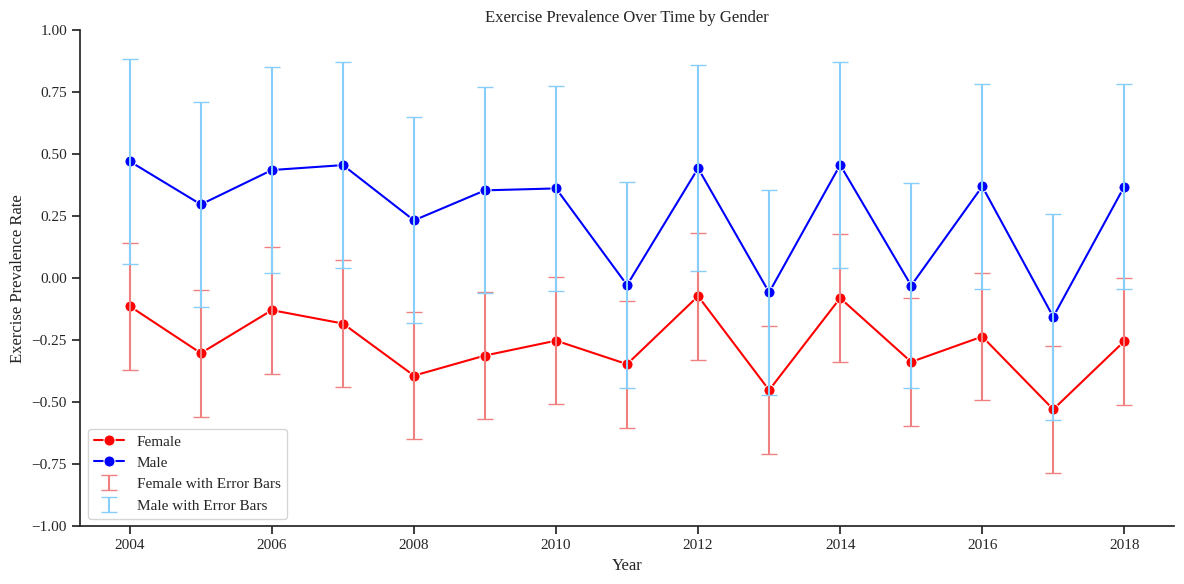

In [ ]:
# Set the style of seaborn
fm.get_font_names()
sns.set(style="ticks", palette='Set2', font='Liberation Serif')

# Create a Seaborn lineplot
plt.figure(figsize=(12, 6))

# Filter the data for males and females
health_exercise_gender_female = health_exercise_gender[health_exercise_gender['Stratification'] == 'Female']
health_exercise_gender_male = health_exercise_gender[health_exercise_gender['Stratification'] == 'Male']
# health_exercise_gender_female = health_exercise_gender.loc['Female']
# health_exercise_gender_male = health_exercise_gender.loc['Male']

# Plot exercise prevalence rate for males in blue and females in red.
sns.lineplot(x='Year', y='exercise_rate_normalized', data=health_exercise_gender_female, marker='o', markersize=8, label='Female', color='red')
sns.lineplot(x='Year', y='exercise_rate_normalized', data=health_exercise_gender_male, marker='o', markersize=8, label='Male', color='blue')

# Get obesity rate data for male and female
exercise_rate_female = health_exercise_gender_female['exercise_rate_normalized']
exercise_rate_male = health_exercise_gender_male['exercise_rate_normalized']

# Calculate the standard deviation
std_dev_female = np.std(exercise_rate_female)
std_dev_male = np.std(exercise_rate_male)

# Assuming error bars with caps based on standard deviation
plt.errorbar(x=health_exercise_gender_female['Year'], y=health_exercise_gender_female['exercise_rate_normalized'],
  yerr=1.96*std_dev_female, fmt='none', color='lightcoral', label='Female with Error Bars', capsize=6)
plt.errorbar(x=health_exercise_gender_male['Year'], y=health_exercise_gender_male['exercise_rate_normalized'],
  yerr=1.96*std_dev_male, fmt='none', color='lightskyblue', label='Male with Error Bars', capsize=6)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Exercise Prevalence Rate')
plt.title('Exercise Prevalence Over Time by Gender')
plt.legend(loc='best')
plt.ylim(-1, 1)
# Delete the upper and right axis
sns.despine()
plt.tight_layout()
plt.show()

Similarly, the trends within gender categories and overall trends demonstrate a remarkable consistency, with obesity rates consistently higher for males in comparison to females. This overarching pattern underscores the need for a nuanced examination of factors influencing the disparities observed, as it suggests a persistent gender-based distinction in obesity prevalence rates.


### **4.1.2 (b) Inferential Analysis**

In [ ]:
#t test exercise rate (male vs. female)
from scipy import stats

#extract exercise rates for males and females
exercise_rate_male = health_exercise_gender[health_exercise_gender['Stratification'] == 'Male']['exercise_rate_normalized']
exercise_rate_female = health_exercise_gender[health_exercise_gender['Stratification'] == 'Female']['exercise_rate_normalized']

#perform t-test
t_statistic, p_value = stats.ttest_ind(exercise_rate_male, exercise_rate_female)

print(f"T-Statistic: {t_statistic}, P-Value: {p_value}")

T-Statistic: 7.989012615998675, P-Value: 1.0620026887905697e-08


A higher absolute value of the t-statistic indicates a greater difference between the two groups. In this case case, a t-statistic of `7.989` is relatively large, which suggests a substantial difference between the exercise rates of males and females in your dataset.

As for the p value, `1.06^(10-8)`, indicates that the observed difference in exercise rates is highly unlikely to have occurred by chance. The p-value is much smaller than the threshold `0.05`, meaning that the difference in exercise rates between males and females in your sample is statistically significant.


### **4.1 (c) Obesity Rates vs. Exercise Rates: A Brief Exploration**

In [ ]:
#extract exercise and obesity rates for males and females
exercise_rate = merged_df['exercise_rate_normalized']
obesity_rate = merged_df['obesity_rate_normalized']

#Pearson correlation coefficient
pearson_corr, p_value_pearson = pearsonr(exercise_rate, obesity_rate)

print(f"Pearson correlation: {pearson_corr}, P-value: {p_value_pearson}")

Pearson correlation: -0.3951513464327558, P-value: 0.14490667813134953


The Pearson correlation coefficient of approximately `-0.395` suggests a moderate negative linear relationship between the obesity and exercise rates, this could mean that higher exercise rates are moderately associated with lower obesity rates, or vice versa.

However, the p-value of approximately `0.145`, which is greater than the common threshold of `0.05`, indicates that this correlation is not statistically significant. In other words, there is not enough evidence to conclude that there is a statistically significant linear relationship between the two variables in the population from which our sample was drawn.

### **4.2 Between the Rate and Search -- Are There Correlations, for Both Obesity and Exercise?**

### **4.2.1 Descriptive Analysis**



To check whether there's a significant correlation between the rate and search quantity, we use the **pearson method** to calculate the correlation coefficient and p values.

Before diving into inferential analysis, we first see **2 regplots** to get an intuitive insight of the relationship between rate of exercise/obesity and corresponding search quantity.

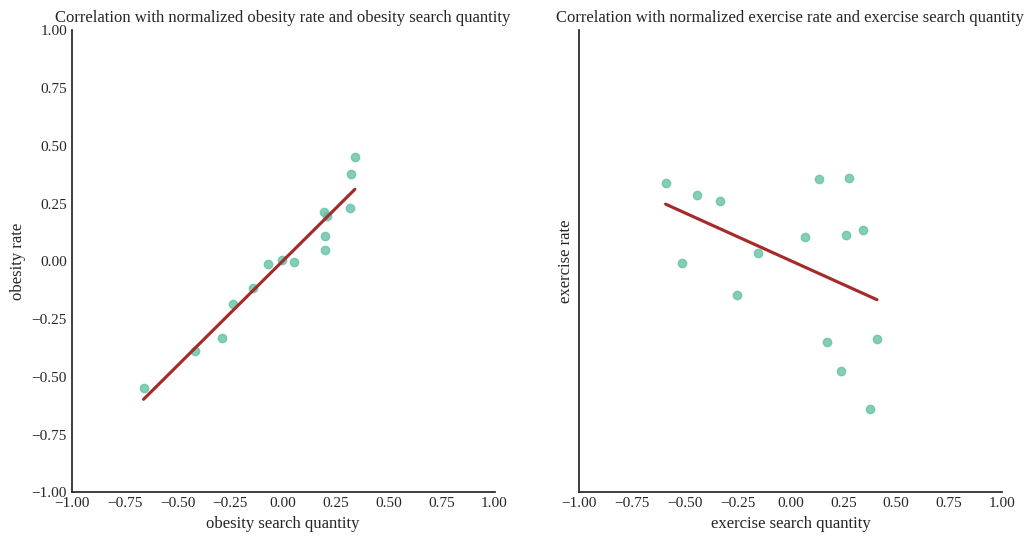

In [ ]:
# Set the style of seaborn
sns.set(style="ticks", palette='Set2', font='Liberation Serif')

# Create a Seaborn subplots to compare difference in exercise and obesity
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.regplot(x='exercise_search_normalized', y='exercise_rate_normalized', data=merged_df, ax=axes[1],line_kws={"color": "brown"},ci=None)
sns.regplot(x='obesity_search_normalized', y='obesity_rate_normalized', data=merged_df, ax=axes[0],line_kws={"color": "brown"},ci=None)
# set up labels and title for exercise plot
axes[1].set_title("Correlation with normalized exercise rate and exercise search quantity",fontsize=12)
axes[1].set_xlim([-1, 1])
axes[1].set_ylim([-1, 1])
axes[1].set_xlabel("exercise search quantity",fontsize=12)
axes[1].set_ylabel("exercise rate",fontsize=12)
axes[1].tick_params(axis='both', which='both', length=0)
# set up labels and title for obesity plot
axes[0].set_title("Correlation with normalized obesity rate and obesity search quantity",fontsize=12)
axes[0].set_xlim([-1, 1])
axes[0].set_ylim([-1, 1])
axes[0].set_xlabel("obesity search quantity",fontsize=12)
axes[0].set_ylabel("obesity rate",fontsize=12)
axes[1].set_yticks([])
axes[0].tick_params(axis='both', which='both', length=0)
# delete the right and top frame of both plots
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

Based on the scatter points and regression line, we discover that points in exercise rate and exercise search quantity seems to be more scattered around the regression line. While the points in obesity rate and obesity exercise search quantity seems to be gathered around the line, which appears to indicate a strong correlation.

Then we will use the pearson method to statistically test the correlation.

###**4.2.2 Inferential Analysis**

In [ ]:
from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient and the p-value.
obesity_correlation, obesity_p_value = pearsonr(merged_df["obesity_rate_normalized"], merged_df["obesity_search_normalized"])
exercise_correlation, exercise_p_value = pearsonr(merged_df["exercise_rate_normalized"], merged_df["exercise_search_normalized"])

# Print the result of the correlation, with coefficient and p-value.
print("For obesity:")
print("Correlation coefficient:", obesity_correlation)
print("P-value:", obesity_p_value)
print()
print("For exercise:")
print("Correlation coefficient:", exercise_correlation)
print("P-value:", exercise_p_value)

For obesity:
Correlation coefficient: 0.9687156603600564
P-value: 3.0224607041820628e-09

For exercise:
Correlation coefficient: -0.44639231148562336
P-value: 0.09532335238179272


In [ ]:
alpha = 0.05  # A commonly-used p-value threshold

p_value_dict={"obesity": obesity_p_value, "exercise":exercise_p_value}

# Display the result of the significance testing.
for k,v in p_value_dict.items():
  if v < alpha:
    print(f"The difference between pairs for {k} is statistically significant, p={v:.4e}")
  else:
    print(f"The difference between pairs for {k} is not statistically significant, p={v:.4e}")

The difference between pairs for obesity is statistically significant, p=3.0225e-09
The difference between pairs for exercise is not statistically significant, p=9.5323e-02


##### **Conclusion for 4.2**

The Pearson correlation coefficient of **obesity rate and search quantity** is approximately `0.968` suggests a moderate positive linear relationship between the obesity rates and search quantity, this could mean that higher obesity rates are moderately associated with higher search, or vice versa.


And the p values is extremely small, less than `0.05`, which means the difference between pairs for obesity rate is statistically significant.

The Pearson correlation coefficient of **exercise rate and search quantity** is approximately `-0.446` suggests a moderate negative linear relationship between the exercise rates and search quantity, this could mean that higher exercise rates are moderately associated with lower search, or vice versa.

However, the p-value is approximately `0.095`, which is greater than the common threshold of `0.05`, indicates that this correlation is not statistically significant. In other words, there is not enough evidence to conclude that there is a statistically significant linear relationship between the two variables in the population from which our sample was drawn.



